We will begin by importing the requisite libraries for training our timeseries model and then reading in our dataset.

In [785]:
# import libraries for time series modeling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sktime.forecasting.var import VAR
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.api import SimpleExpSmoothing, ExponentialSmoothing
import pmdarima as pmd

In [786]:
# read in data frame
sf_dev_projs = pd.read_csv('./data/five_yr_pipeline.csv', low_memory = False)

In [787]:
# displays the head of the data frame
sf_dev_projs.head()

,landuse,nameaddr,entitled,beststat,bestdate,units,tcocfcdate,tcocfcunits,unitsnet,pipelineunits,...,heightbul,pda,longitude,latitude,year,qtr,yearqtr,latlong,currentpolicedistricts,affordable
0,Resident,836 48TH AV,1,CONSTRUCTION,09/20/2021 11:44:06 AM,2.0,None applied,0.0,1.0,1.0,...,40-X,Richmond Corridors,-122.508817,37.772600,2022.0,Q4,2022_Q4,POINT (-122.5088171 37.7725997),8.0,0.0
1,Vacant,735 BRYANT ST,1,CONSTRUCTION,07/26/2019 12:00:00 AM,0.0,None applied,0.0,0.0,0.0,...,270-CS,Eastern Neighborhoods,-122.400848,37.776946,2022.0,Q4,2022_Q4,POINT (-122.400848374 37.7769458793),1.0,0.0
2,Resident,2626 GRIFFITH ST,1,CONSTRUCTION,10/20/2021 11:10:35 AM,1.0,None applied,0.0,1.0,1.0,...,40-X,Bayview/Southeast Neighborhoods,-122.388080,37.718621,2022.0,Q4,2022_Q4,POINT (-122.388080214 37.7186214874),2.0,0.0
3,Resident,49 SUSSEX ST,1,BP APPROVED,12/13/2019 09:43:07 AM,1.0,None applied,0.0,1.0,1.0,...,40-X,J Church and Mission Corridor,-122.433855,37.736508,2022.0,Q4,2022_Q4,POINT (-122.433855046 37.7365078557),9.0,0.0
4,Resident,1247 BOSWORTH ST,1,BP ISSUED,08/10/2022 12:00:00 AM,1.0,None applied,0.0,1.0,1.0,...,40-X,0,-122.441421,37.735635,2022.0,Q4,2022_Q4,POINT (-122.441420855 37.7356345978),9.0,0.0


Although we used many more features in our clustering models, for the timeseries models we should only need the "beststat" and "bestdate" for charting the progress of where a project is in the development pipeline over time and our focal variables of net units and net affordable units. We shall also pull the year and quarter data for assigning ongoing projects to particular quarters in time.

In [788]:
# creates a copy of the data frame with the subset of columns required for the timeseries models
dev_projs_time = sf_dev_projs[['beststat', 'bestdate', 'unitsnet', 'affordablenet', 'yearqtr']].copy()

dev_projs_time

,beststat,bestdate,unitsnet,affordablenet,yearqtr
0,CONSTRUCTION,09/20/2021 11:44:06 AM,1.0,0.0,2022_Q4
1,CONSTRUCTION,07/26/2019 12:00:00 AM,0.0,0.0,2022_Q4
2,CONSTRUCTION,10/20/2021 11:10:35 AM,1.0,0.0,2022_Q4
3,BP APPROVED,12/13/2019 09:43:07 AM,1.0,0.0,2022_Q4
4,BP ISSUED,08/10/2022 12:00:00 AM,1.0,0.0,2022_Q4
...,...,...,...,...,...
43197,BP FILED,02/09/2017 12:00:00 AM,0.0,0.0,2018_Q1
43198,PL FILED,02/01/2018 12:00:00 AM,3.0,0.0,2018_Q1
43199,PL FILED,03/16/2018 12:00:00 AM,2.0,0.0,2018_Q1
43200,CONSTRUCTION,03/08/2018 12:00:00 AM,0.0,0.0,2018_Q1


Before continuing with our timeseries, we must preprocess our data with a datetime index here. We have two options, one to use the bestdate column and another to use the yearqtr column. Although the bestdate is a more accurate measure of exactly when a project is reported to enter the next phase in a project, it may not be the best in determining how many total projects or total units are extant in a given quarter since projects may stall in a phase of the pipeline for several quarters or perhaps years. However, the bestdate column could give us a more accurate picture of how frequently new construction projects actually break ground on construction of new units. Either way, we begin first by focusing our efforts on the construction phase of these development projects and then comparing the timeseries model of the bestdate in comparison to the yearqtr reports and evaluate which is a better measure to predicting future construction of net units and net affordable units.

We shall begin by masking for only construction for best stat and making two copies of the data frame, one in which the oldest bestdate is the index and another in which the yearqtr is the index.

In [789]:
# make a copy of the data frame with only the construction status
constr = dev_projs_time[dev_projs_time['beststat'] == 'CONSTRUCTION'].copy()

constr

,beststat,bestdate,unitsnet,affordablenet,yearqtr
0,CONSTRUCTION,09/20/2021 11:44:06 AM,1.0,0.0,2022_Q4
1,CONSTRUCTION,07/26/2019 12:00:00 AM,0.0,0.0,2022_Q4
2,CONSTRUCTION,10/20/2021 11:10:35 AM,1.0,0.0,2022_Q4
5,CONSTRUCTION,10/07/2019 12:00:00 AM,1.0,0.0,2022_Q4
8,CONSTRUCTION,10/09/2019 12:00:00 AM,1.0,0.0,2022_Q4
...,...,...,...,...,...
43162,CONSTRUCTION,02/02/2018 12:00:00 AM,0.0,0.0,2018_Q1
43167,CONSTRUCTION,04/04/2018 12:00:00 AM,0.0,0.0,2018_Q1
43179,CONSTRUCTION,01/04/2018 12:00:00 AM,0.0,0.0,2018_Q1
43186,CONSTRUCTION,12/14/2017 12:00:00 AM,0.0,0.0,2018_Q1


In [790]:
# convert bestdate dates to datetime
constr['bestdate'] = pd.to_datetime(constr['bestdate'], format = 'mixed')

In [791]:
# shows value counts of yearqtr, including nulls
constr['yearqtr'].value_counts(dropna = False)

yearqtr
2022_Q2    544
2022_Q3    533
2022_Q4    511
2021_Q2    469
2021_Q3    427
2020_Q1    427
2019_Q4    413
2019_Q3    406
2022_Q1    398
2021_Q4    395
NaN        389
2020_Q2    388
2019_Q1    354
2018_Q4    339
2020_Q3    336
2018_Q3    329
2018_Q2    326
2020_Q4    306
2018_Q1    291
2021_Q1    254
Name: count, dtype: int64

Looking at the value counts, we can see that there is only one quarter missing, 2019 quarter 2, and the total nulls resemble the total number of values in other quarterly reports, so we can impute that these nulls are likely missing from that quarter exclusively.

In [792]:
# fill nulls with 2019_Q2
constr['yearqtr'].fillna('2019_Q2', inplace = True)

In [793]:
# check value counts to verify nulls have been imputed
constr['yearqtr'].value_counts(dropna = False)

yearqtr
2022_Q2    544
2022_Q3    533
2022_Q4    511
2021_Q2    469
2021_Q3    427
2020_Q1    427
2019_Q4    413
2019_Q3    406
2022_Q1    398
2021_Q4    395
2019_Q2    389
2020_Q2    388
2019_Q1    354
2018_Q4    339
2020_Q3    336
2018_Q3    329
2018_Q2    326
2020_Q4    306
2018_Q1    291
2021_Q1    254
Name: count, dtype: int64

In [794]:
# map a date to each quarter
constr['yearqtr'] = constr['yearqtr'].map({'2018_Q1': '03/31/2018',
                                           '2018_Q2': '06/30/2018',
                                           '2018_Q3': '09/30/2018',
                                           '2018_Q4': '12/31/2018',
                                           '2019_Q1': '03/31/2019',
                                           '2019_Q2': '06/30/2019',
                                           '2019_Q3': '09/30/2019',
                                           '2019_Q4': '12/31/2019',
                                           '2020_Q1': '03/31/2020',
                                           '2020_Q2': '06/30/2020',
                                           '2020_Q3': '09/30/2020',
                                           '2020_Q4': '12/31/2020',
                                           '2021_Q1': '03/31/2021',
                                           '2021_Q2': '06/30/2021',
                                           '2021_Q3': '09/30/2021',
                                           '2021_Q4': '12/31/2021',
                                           '2022_Q1': '03/31/2022',
                                           '2022_Q2': '06/30/2022',
                                           '2022_Q3': '09/30/2022',
                                           '2022_Q4': '12/31/2022'
                                          })

In [795]:
# convert yearqtr dates to datetime
constr['yearqtr'] = pd.to_datetime(constr['yearqtr'])

In [796]:
# check data types
constr.dtypes

beststat                 object
bestdate         datetime64[ns]
unitsnet                float64
affordablenet           float64
yearqtr          datetime64[ns]
dtype: object

We now have a data frame with the two relevant dates in a datetime format. We shall begin first with making the bestdate our index and then modeling our timeseries using this index for both net units and affordable units. This timeseries model ought to be a better predictor of when new construction begins as opposed to our quarterly index which will be a better predictor for how many units are in the construction pipeline in a given quarter.

We shall start by dropping any duplicates to get the first chronologically occurring instance of the bestdate for new construction and then resetting and sorting our index. Also for the sake of comparison for when we look at quarterly data, we shall look only at 2018-2022, even though there will certainly be new construction in this dataset dating to years prior to 2018.

In [797]:
# make a date frame for preprocessing with bestdate index
constr_bestdate = constr.copy()

In [798]:
# drop duplicates to get only the first occurring instance of a bestdate
constr_bestdate = constr_bestdate.drop_duplicates(subset = 'bestdate')

constr_bestdate

,beststat,bestdate,unitsnet,affordablenet,yearqtr
0,CONSTRUCTION,2021-09-20 11:44:06,1.0,0.0,2022-12-31
1,CONSTRUCTION,2019-07-26 00:00:00,0.0,0.0,2022-12-31
2,CONSTRUCTION,2021-10-20 11:10:35,1.0,0.0,2022-12-31
5,CONSTRUCTION,2019-10-07 00:00:00,1.0,0.0,2022-12-31
8,CONSTRUCTION,2019-10-09 00:00:00,1.0,0.0,2022-12-31
...,...,...,...,...,...
42850,CONSTRUCTION,2017-03-21 00:00:00,1.0,0.0,2018-03-31
42952,CONSTRUCTION,2017-12-12 00:00:00,1.0,0.0,2018-03-31
42983,CONSTRUCTION,2018-02-05 00:00:00,1.0,0.0,2018-03-31
43004,CONSTRUCTION,2017-08-03 00:00:00,1.0,0.0,2018-03-31


In [799]:
# set index to bestdate
constr_bestdate.set_index('bestdate', inplace = True)

constr_bestdate

,beststat,unitsnet,affordablenet,yearqtr
bestdate,,,,
2021-09-20 11:44:06,CONSTRUCTION,1.0,0.0,2022-12-31
2019-07-26 00:00:00,CONSTRUCTION,0.0,0.0,2022-12-31
2021-10-20 11:10:35,CONSTRUCTION,1.0,0.0,2022-12-31
2019-10-07 00:00:00,CONSTRUCTION,1.0,0.0,2022-12-31
2019-10-09 00:00:00,CONSTRUCTION,1.0,0.0,2022-12-31
...,...,...,...,...
2017-03-21 00:00:00,CONSTRUCTION,1.0,0.0,2018-03-31
2017-12-12 00:00:00,CONSTRUCTION,1.0,0.0,2018-03-31
2018-02-05 00:00:00,CONSTRUCTION,1.0,0.0,2018-03-31


In [800]:
# sort index according to datetime
constr_bestdate.sort_index(inplace = True)

constr_bestdate

,beststat,unitsnet,affordablenet,yearqtr
bestdate,,,,
2007-10-01,CONSTRUCTION,401.0,401.0,2018-06-30
2009-04-09,CONSTRUCTION,0.0,0.0,2020-06-30
2014-02-04,CONSTRUCTION,1.0,0.0,2018-06-30
2014-05-21,CONSTRUCTION,1.0,0.0,2018-06-30
2014-05-27,CONSTRUCTION,41.0,0.0,2022-12-31
...,...,...,...,...
2022-11-30,CONSTRUCTION,1.0,0.0,2022-12-31
2022-12-08,CONSTRUCTION,1.0,0.0,2022-12-31
2022-12-13,CONSTRUCTION,2.0,0.0,2022-12-31


In [801]:
# index only for the years 2018 through 2022
constr_bestdate = constr_bestdate.loc[(constr_bestdate.index >= '2018-01-01')
                                      & (constr_bestdate.index < '2023-01-01')].copy()

constr_bestdate

,beststat,unitsnet,affordablenet,yearqtr
bestdate,,,,
2018-01-03,CONSTRUCTION,2.0,0.0,2018-03-31
2018-01-04,CONSTRUCTION,0.0,0.0,2018-09-30
2018-01-08,CONSTRUCTION,1.0,0.0,2019-03-31
2018-01-10,CONSTRUCTION,0.0,0.0,2018-09-30
2018-01-11,CONSTRUCTION,2.0,0.0,2018-06-30
...,...,...,...,...
2022-11-23,CONSTRUCTION,1.0,0.0,2022-12-31
2022-11-30,CONSTRUCTION,1.0,0.0,2022-12-31
2022-12-08,CONSTRUCTION,1.0,0.0,2022-12-31


In [802]:
# drop the beststat & yearqtr column
constr_bestdate.drop(columns = ['beststat', 'yearqtr'], inplace = True)

constr_bestdate.head()

,unitsnet,affordablenet
bestdate,,
2018-01-03,2.0,0.0
2018-01-04,0.0,0.0
2018-01-08,1.0,0.0
2018-01-10,0.0,0.0
2018-01-11,2.0,0.0


We are now prepared to explore our time series data for new construction and begin fitting multiple models.

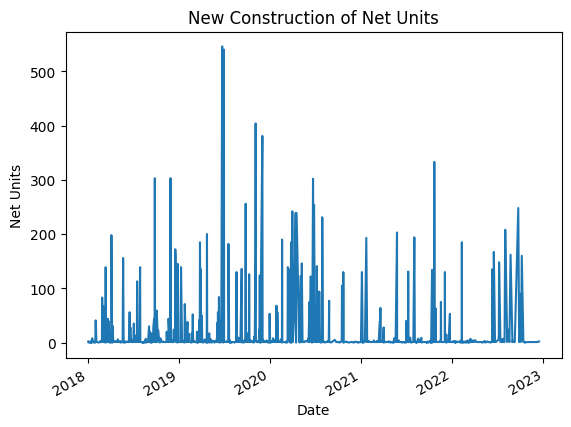

In [803]:
# displays line plot of new construction of net units
constr_bestdate.groupby('bestdate')['unitsnet'].sum().plot(xlabel = 'Date', 
                                                           ylabel = 'Net Units', 
                                                           title = 'New Construction of Net Units');

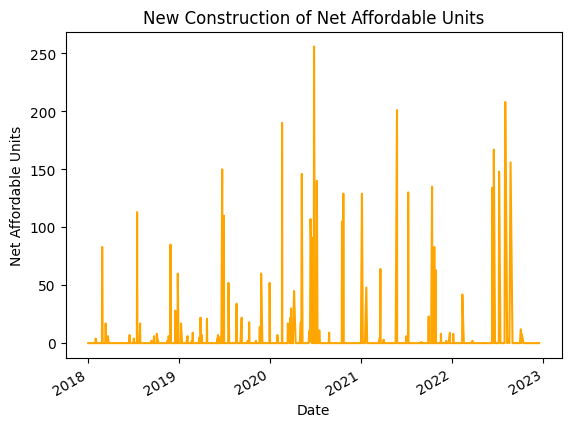

In [804]:
# displays line plot of new construction of net affordable units
constr_bestdate.groupby('bestdate')['affordablenet'].sum().plot(xlabel = 'Date', 
                                                                ylabel = 'Net Affordable Units', 
                                                                title = 'New Construction of Net Affordable Units',
                                                                color = 'orange'
                                                               );

The graphs above show the time series for the new construction of net units and net affordable units for five years. However, both of these graphs appear very jagged and may prove difficult to model without overfitting unless we can smooth the data. First, we will resample our dataset on a monthly basis since there are almost certainly some new projects which break ground every month but not necessarily every week.

In [805]:
# resamples data on a monthly basis
constr_bestdate_monthly = constr_bestdate.resample('M').mean()

constr_bestdate_monthly.head()

,unitsnet,affordablenet
bestdate,,
2018-01-31,1.428571,0.00
2018-02-28,11.250000,7.25
2018-03-31,16.050000,1.15
2018-04-30,12.550000,0.00
2018-05-31,11.600000,0.00


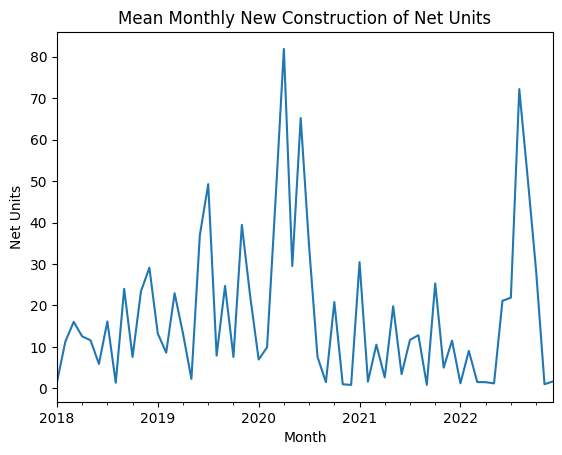

In [806]:
# displays line plot of mean monthly new construction of net units
constr_bestdate_monthly['unitsnet'].plot(xlabel = 'Month', 
                                         ylabel = 'Net Units', 
                                         title = 'Mean Monthly New Construction of Net Units');

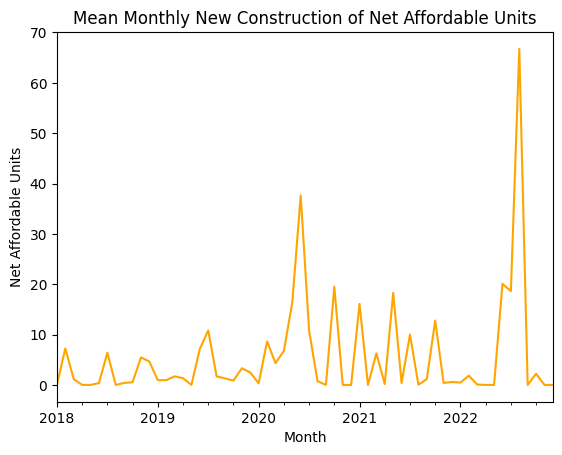

In [807]:
# displays line plot of mean monthly new construction of net affordable units
constr_bestdate_monthly['affordablenet'].plot(xlabel = 'Month', 
                                              ylabel = 'Net Affordable Units', 
                                              title = 'Mean Monthly New Construction of Net Affordable Units',
                                              color = 'orange'
                                             );

We can now see above the graphs of the mean monthly net units and net affordable units under new construction.

Next, we shall look at the autocorrelations and partial autocorrelations to check for seasonanility for modeling purposes. We shall also look at our results from the Augmented Dickey-Fuller Test to surmise how much differencing will make sense as we model moving forward.

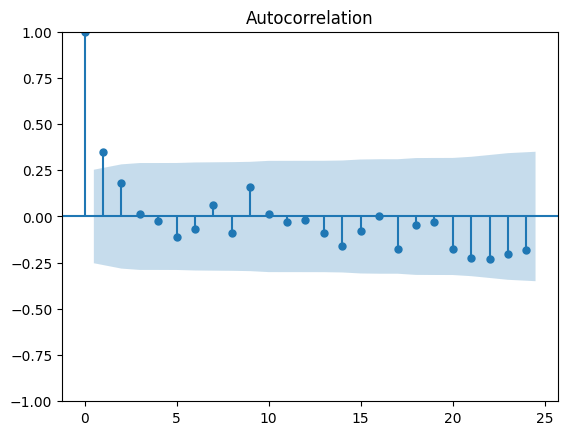

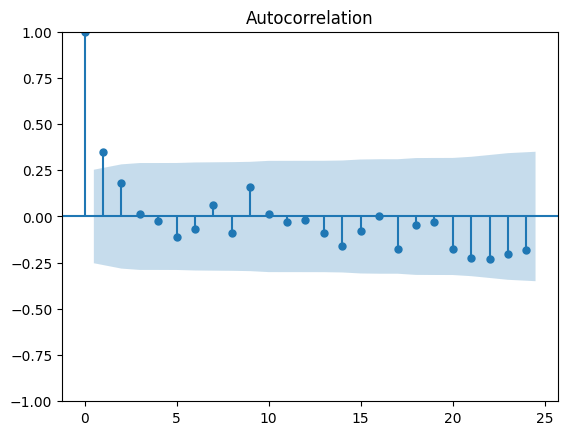

In [808]:
# plots autocorrelation for net units over 24 lag (2 years)
plot_acf(constr_bestdate_monthly['unitsnet'], lags = 24)

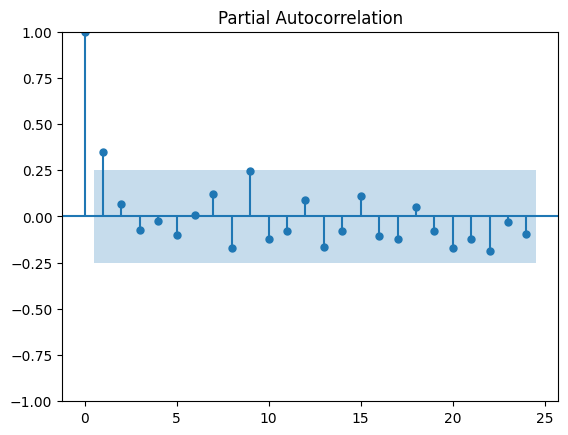

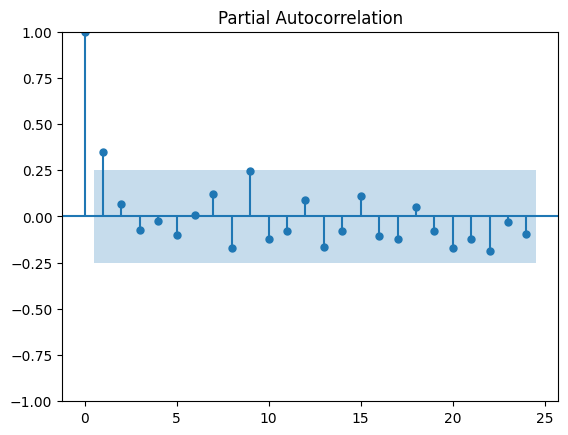

In [809]:
# plots partial autocorrelation for net units over 24 lag (2 years)
plot_pacf(constr_bestdate_monthly['unitsnet'], lags = 24)

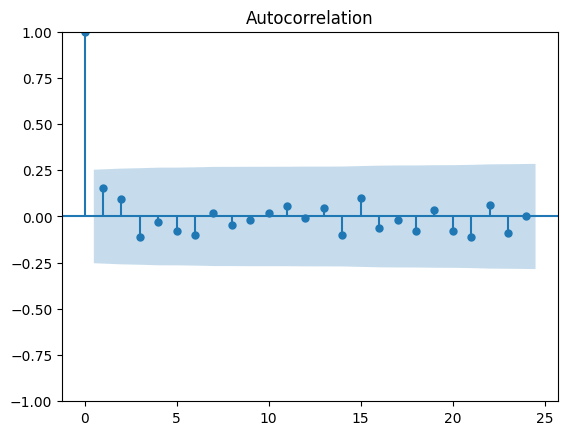

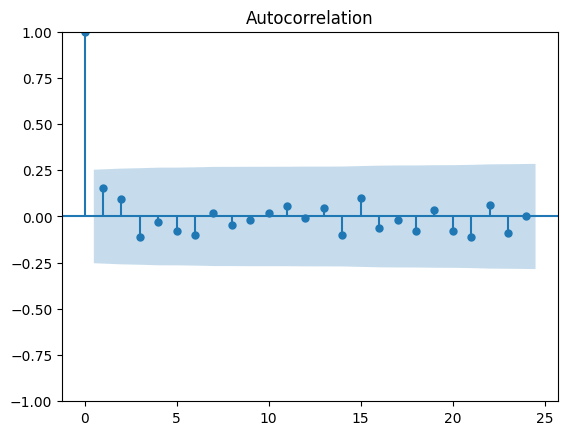

In [810]:
# plots autocorrelation for net affordable units over 24 lag (2 years)
plot_acf(constr_bestdate_monthly['affordablenet'], lags = 24)

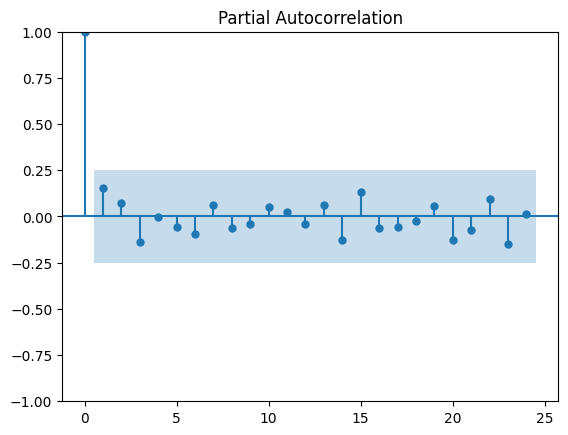

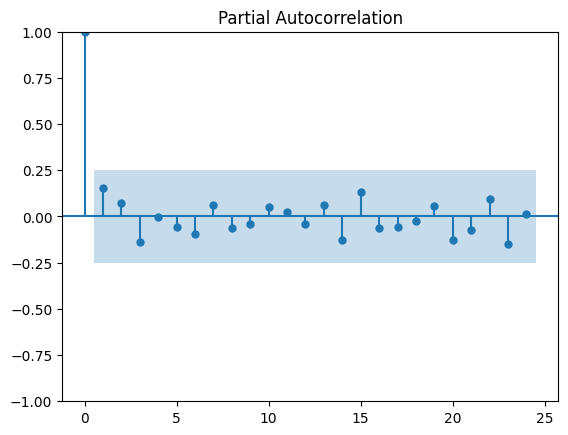

In [811]:
# plots partial autocorrelation for net units over 24 lag (2 years)
plot_pacf(constr_bestdate_monthly['affordablenet'], lags = 24)

Looking at the autocorrelations and partial autocorrelations for the net units, we can see that it appears like there is only a statistically significant autocorrelation at a lag of one month. Even at two months, we don't see a significant autocorrelation. Additionally, there is no clear seasonality in these autocorrelations, indicating no consistent pattern for new construction. Checking the autocorrelation and partial autocorrelation plots for net affordable units there is not even a significant one month lag correlation. This suggests that our subsequent time series models are going to be extremely hard to predict the net units or net affordable units moving forward.

Before moving to our first naive forecast, we shall check the Augmented Dickey-Fuller test for stationarity and determine whether our data are really apt for forecasting in the first place.

In [812]:
# creates a function to return the output of the Dickey-Fuller test
def interpret_dftest(dftest):
    dfoutput = pd.DataFrame(dftest[0:3], index=['Test Statistic','p-value', 'Lag Used'])
    return dfoutput

In [813]:
# Run ADF test on the net units
interpret_dftest(adfuller(constr_bestdate_monthly['unitsnet']))

,0
Test Statistic,-5.224083
p-value,0.000008
Lag Used,0.000000


In [814]:
interpret_dftest(adfuller(constr_bestdate_monthly['affordablenet']))

,0
Test Statistic,-6.449181e+00
p-value,1.538679e-08
Lag Used,0.000000e+00


The good news is looking at our Augmented Dickey-Fuller Test we can see that the net units shows a p-value of 0.000008 which is well below the 0.01 threshold we commonly use to reject the null hypothesis. The same is true for our net affordable units with a p-value of 0.000000015. In both of these cases, we can say with 99% confidence that both of these time series datasets have sufficient stationarity at 0 lags. This will inform our methodology especially when we get to our vector autoregression of both variables at the same time.

We will look at net units first and create and evaluate several time series models to determine which might be the best for predicting future new construction of net units. We shall begin with a train test split and set up a naive forecast.

In [815]:
# create a train test split
train, test = train_test_split(constr_bestdate_monthly[['unitsnet']],
                                                    test_size = 0.2,
                                                    shuffle = False)

In [816]:
# check the train shape
print(train.shape)

(48, 1)


In [817]:
# check the test shape
test.shape

(12, 1)

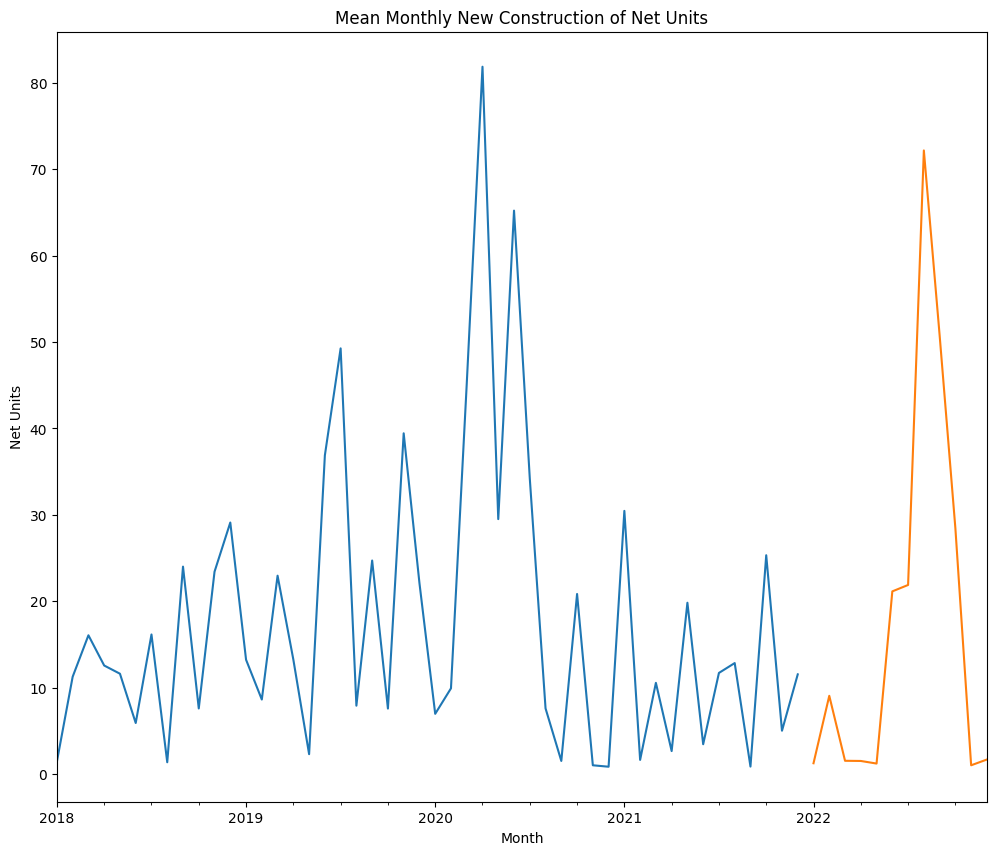

In [818]:
# displays graph of train and test data for net units
train['unitsnet'].plot()
test['unitsnet'].plot(figsize = (12, 10), 
                      xlabel = 'Month',
                      ylabel = 'Net Units',
                      title = 'Mean Monthly New Construction of Net Units');

In [819]:
# creates a prediction data frame which is a copy of the test data
units_preds = test.copy()

units_preds

,unitsnet
bestdate,
2022-01-31,1.235294
2022-02-28,9.043478
2022-03-31,1.520000
2022-04-30,1.500000
2022-05-31,1.200000
2022-06-30,21.133333
2022-07-31,21.875000
2022-08-31,72.181818
2022-09-30,50.800000


In [820]:
# creates a prediction column based on the last value in the train dataset
units_preds['last'] = train['unitsnet'][-1]

units_preds

,unitsnet,last
bestdate,,
2022-01-31,1.235294,11.526316
2022-02-28,9.043478,11.526316
2022-03-31,1.520000,11.526316
2022-04-30,1.500000,11.526316
2022-05-31,1.200000,11.526316
2022-06-30,21.133333,11.526316
2022-07-31,21.875000,11.526316
2022-08-31,72.181818,11.526316
2022-09-30,50.800000,11.526316


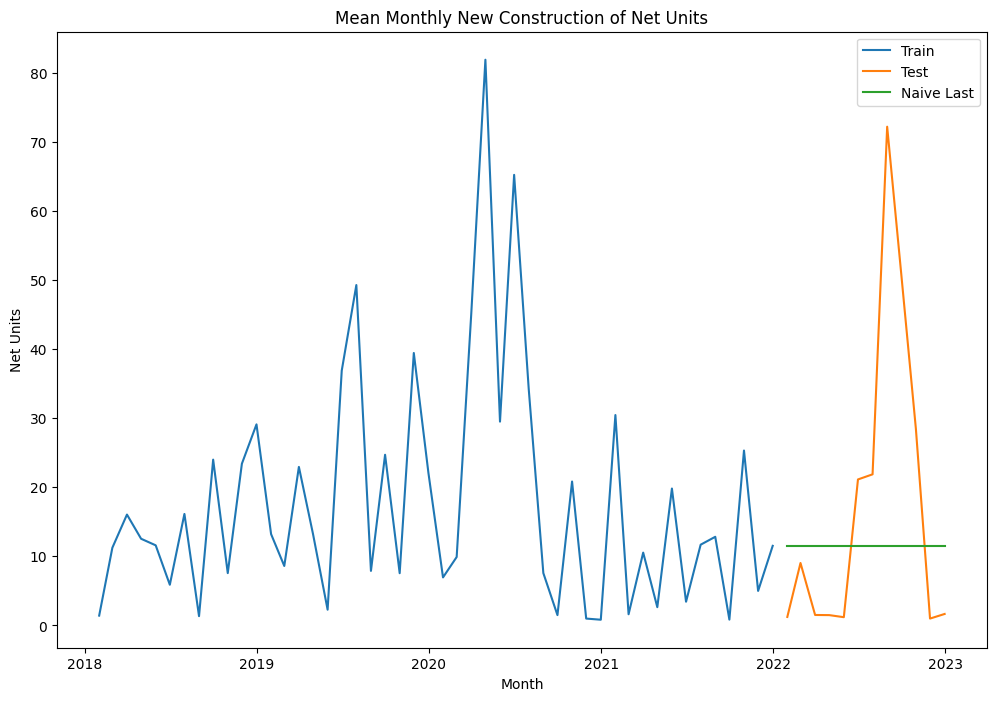

In [821]:
# displays the graph of the train, test and naive last data
plt.figure(figsize = (12, 8))

plt.plot(train.index, train['unitsnet'], label = 'Train')
plt.plot(test.index, test['unitsnet'], label = 'Test')
plt.plot(units_preds.index, units_preds['last'], label = 'Naive Last')

plt.xlabel('Month')
plt.ylabel('Net Units')
plt.legend(loc = 'best')
plt.title('Mean Monthly New Construction of Net Units');

In [822]:
# shows the root mean squared error for the naive last prediction
mean_squared_error(units_preds['unitsnet'], units_preds['last'], squared = False)

22.975525286051887

In [823]:
# creates a column the simple mean based on the training historical mean
units_preds['simple_mean'] = train['unitsnet'].mean()

units_preds.head()

,unitsnet,last,simple_mean
bestdate,,,
2022-01-31,1.235294,11.526316,17.683992
2022-02-28,9.043478,11.526316,17.683992
2022-03-31,1.520000,11.526316,17.683992
2022-04-30,1.500000,11.526316,17.683992
2022-05-31,1.200000,11.526316,17.683992


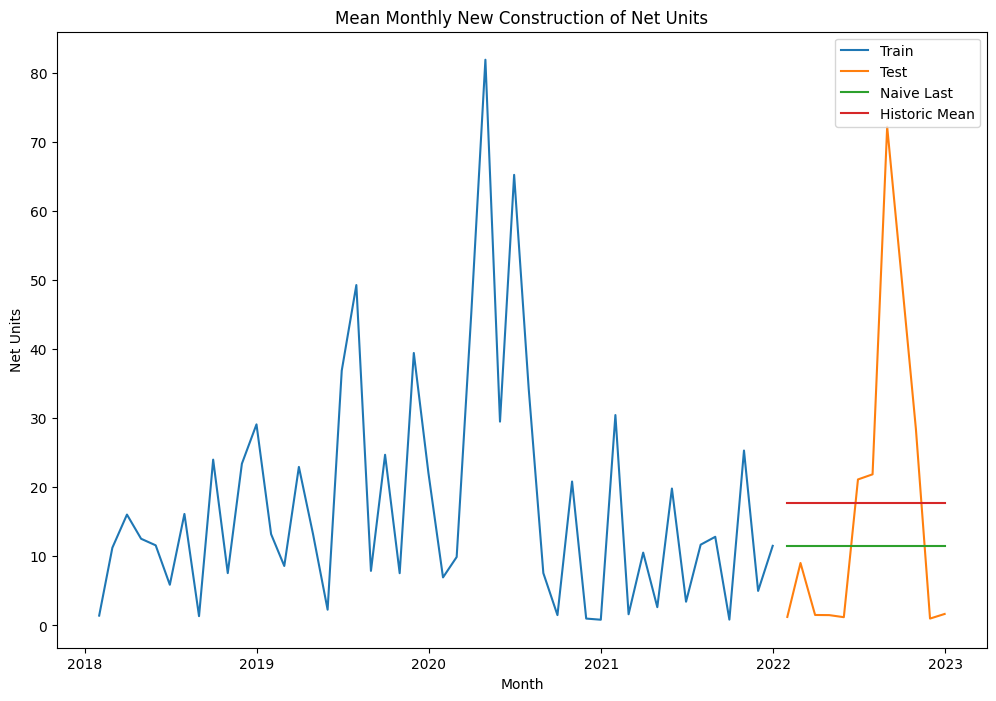

In [824]:
# graphs the train and test data with both the naive last and historic mean
plt.figure(figsize = (12, 8))

plt.plot(train.index, train['unitsnet'], label = 'Train')
plt.plot(test.index, test['unitsnet'], label = 'Test')
plt.plot(units_preds.index, units_preds['last'], label = 'Naive Last')
plt.plot(units_preds.index, units_preds['simple_mean'], label = 'Historic Mean')

plt.xlabel('Month')
plt.ylabel('Net Units')
plt.legend(loc = 'best')
plt.title('Mean Monthly New Construction of Net Units');

In [825]:
# shows the root mean squared error for the historical mean
mean_squared_error(units_preds['unitsnet'], units_preds['simple_mean'], squared = False)

22.149077390373808

In the cells above we have graphed our train and test data against our naive last prediction and our historical mean. Based on the root mean squared error in both cases, the historical mean performs slightly better with an RMSE of ~22.15 net units in comparison to the naive last with an RMSE of ~22.98 net units. However, in both cases, we can see that both perform very poorly, as the naive last prediction is ~11.5 net units and the historic mean is ~17.7 net units, meaning that the RMSE is in the range of negative net units even though there is no month in which the average drops below zero. We will assume for the time being that these data do not have any seasonality based on our partial autocorrelation plots above, so we shall avoid time series models with a seasonality component. We shall first train some exponential smoothing models to assess whether they perform better than our null models.

In [826]:
# fit a simple exponential smoothing model
simexp = SimpleExpSmoothing(train['unitsnet']).fit(smoothing_level = .5, optimized = False)

In [827]:
# shows a summary of the exponential smoothing
simexp.summary()

Dep. Variable:,unitsnet,No. Observations:,48
Model:,SimpleExpSmoothing,SSE,14571.629
Optimized:,False,AIC,278.350
Trend:,None,BIC,282.093
Seasonal:,None,AICC,279.281
Seasonal Periods:,None,Date:,"Sat, 16 Sep 2023"
Box-Cox:,False,Time:,16:08:26
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.5000000,alpha,False
initial_level,1.4285714,l.0,False


In [828]:
# adds the simple exponential smoothing forecast to the predictions
units_preds['simexp'] = simexp.forecast(len(test))

units_preds

,unitsnet,last,simple_mean,simexp
bestdate,,,,
2022-01-31,1.235294,11.526316,17.683992,10.943972
2022-02-28,9.043478,11.526316,17.683992,10.943972
2022-03-31,1.520000,11.526316,17.683992,10.943972
2022-04-30,1.500000,11.526316,17.683992,10.943972
2022-05-31,1.200000,11.526316,17.683992,10.943972
2022-06-30,21.133333,11.526316,17.683992,10.943972
2022-07-31,21.875000,11.526316,17.683992,10.943972
2022-08-31,72.181818,11.526316,17.683992,10.943972
2022-09-30,50.800000,11.526316,17.683992,10.943972


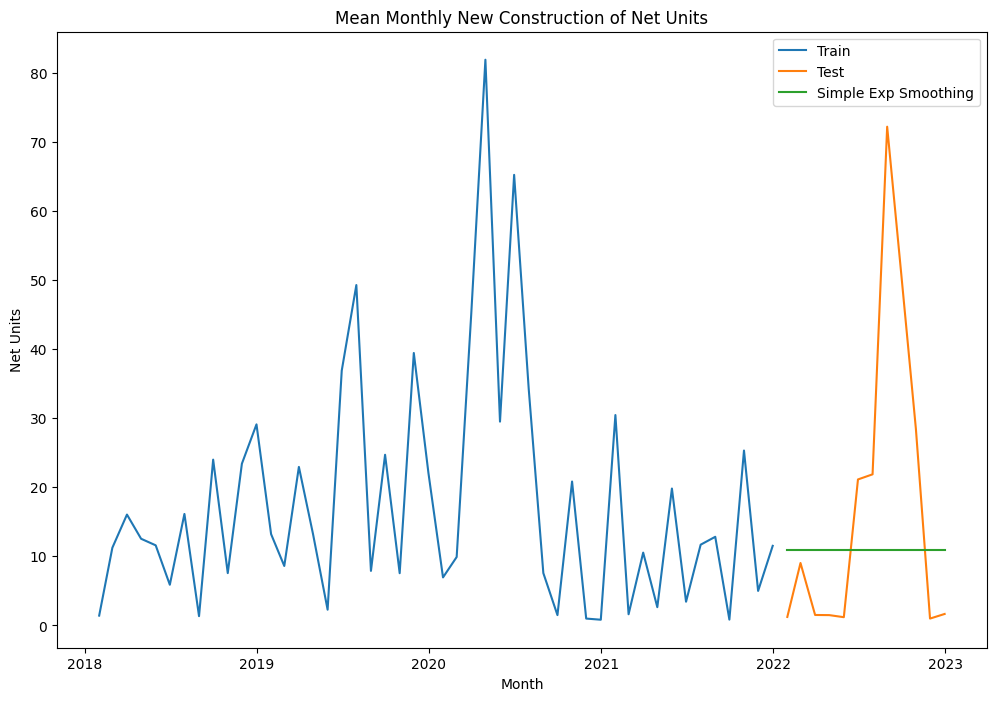

In [829]:
# graphs the train and test data with both the naive last and historic mean
plt.figure(figsize = (12, 8))

plt.plot(train.index, train['unitsnet'], label = 'Train')
plt.plot(test.index, test['unitsnet'], label = 'Test')
plt.plot(units_preds.index, units_preds['simexp'], label = 'Simple Exp Smoothing')

plt.legend(loc = 'best')
plt.xlabel('Month')
plt.ylabel('Net Units')
plt.title('Mean Monthly New Construction of Net Units');

In [830]:
# shows the root mean squared error for the historical mean
mean_squared_error(units_preds['unitsnet'], units_preds['simexp'], squared = False)

23.137127243229454

In [831]:
# fits a Holt Winters model
hw = ExponentialSmoothing(train['unitsnet'],
                         trend = 'mul').fit()

In [832]:
# shows a summary of Holt Winters data
hw.summary()

Dep. Variable:,unitsnet,No. Observations:,48
Model:,ExponentialSmoothing,SSE,13412.507
Optimized:,True,AIC,278.372
Trend:,Multiplicative,BIC,285.856
Seasonal:,None,AICC,280.420
Seasonal Periods:,None,Date:,"Sat, 16 Sep 2023"
Box-Cox:,False,Time:,16:08:34
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.2240842,alpha,True
smoothing_trend,0.000000,beta,True


In [833]:
# add Holt Winters forecast to prediction data frame
units_preds['hw'] = hw.forecast(len(test))

units_preds

,unitsnet,last,simple_mean,simexp,hw
bestdate,,,,,
2022-01-31,1.235294,11.526316,17.683992,10.943972,10.069621
2022-02-28,9.043478,11.526316,17.683992,10.943972,9.850475
2022-03-31,1.520000,11.526316,17.683992,10.943972,9.636098
2022-04-30,1.500000,11.526316,17.683992,10.943972,9.426387
2022-05-31,1.200000,11.526316,17.683992,10.943972,9.221240
2022-06-30,21.133333,11.526316,17.683992,10.943972,9.020558
2022-07-31,21.875000,11.526316,17.683992,10.943972,8.824243
2022-08-31,72.181818,11.526316,17.683992,10.943972,8.632200
2022-09-30,50.800000,11.526316,17.683992,10.943972,8.444337


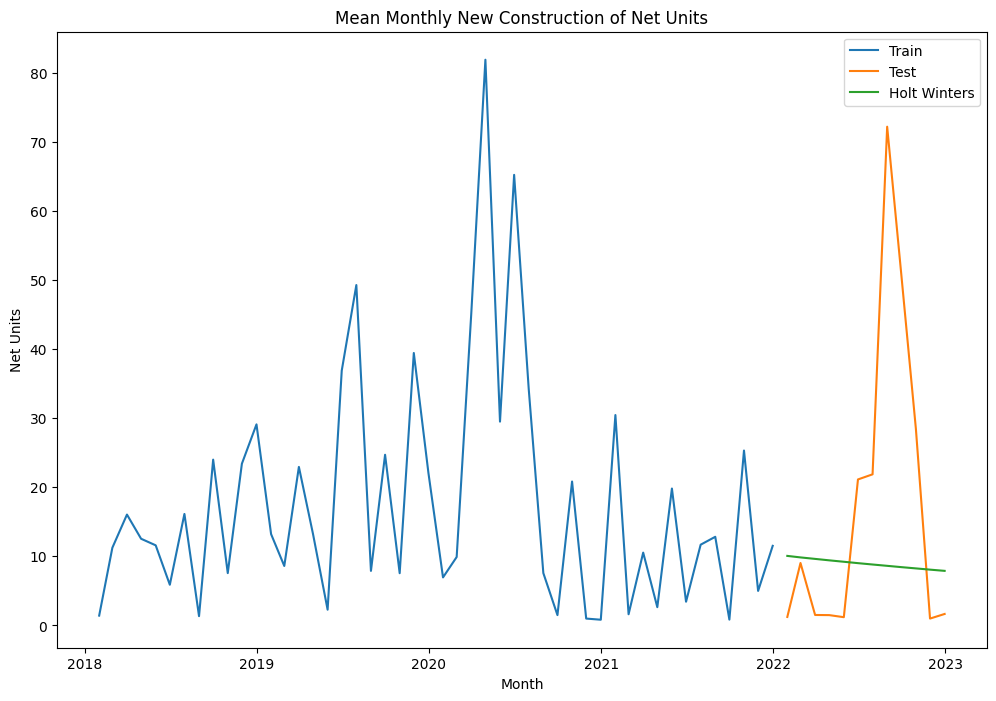

In [834]:
# graphs the train and test data with Holt Winters
plt.figure(figsize = (12, 8))

plt.plot(train.index, train['unitsnet'], label = 'Train')
plt.plot(test.index, test['unitsnet'], label = 'Test')
plt.plot(units_preds.index, units_preds['hw'], label = 'Holt Winters')

plt.legend(loc = 'best')
plt.xlabel('Month')
plt.ylabel('Net Units')
plt.title('Mean Monthly New Construction of Net Units');

In [835]:
# shows the root mean squared error for Holt Winters
mean_squared_error(units_preds['unitsnet'], units_preds['hw'], squared = False)

24.010025404545605

In evaluating our simple exponential smoothing model, we can see a root mean squared error of ~23.14 net units which is performing more poorly than both our naive last and historical mean null models. Therefore, the exponential smoothing model is probably not helpful in forecasting our net units. As stated earlier, we have a dataset which does not show any seasonal trends. However, to be sure, we also attempted to train a Holt Winters model, using a multiplicative trend since the local minimina and maxima do seem to vary. Looking at the Holt Winters results, we are arriving at an RMSE of ~24.01 net units, performing even worse than the simple exponential smoothing model. We can also see this in both summaries above in which the AIC scores on both models is approximately 285, with the Holt Winters slightly higher. This is not surprising because Holt Winters presumes some seasonality, but we saw no evidence of this in our partial autocorrelation. We can say confidently now though that Holt Winters is not a good fit for our time series model.

For our last univariate time series model of these mean monthly net units, we shall fit an ARIMA model, once again checking for any seasonality just in case.

In [836]:
# instantiate
model = pmd.auto_arima(train['unitsnet'], m = 12, trace = True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=0.80 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=411.753, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=412.455, Time=0.13 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=413.201, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=445.191, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=413.752, Time=0.14 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=413.752, Time=0.07 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=415.752, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=410.548, Time=0.02 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=412.417, Time=0.05 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=411.734, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=411.558, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=411.241, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AI

In [837]:
# display model output
model

ARIMA(order=(1, 0, 0), scoring_args={}, seasonal_order=(0, 0, 0, 12),
      suppress_warnings=True)

In [838]:
# preview ARIMA predictions
model.predict()

2022-01-31    16.000683
2022-02-28    17.138680
2022-03-31    17.428115
2022-04-30    17.501729
2022-05-31    17.520451
2022-06-30    17.525213
2022-07-31    17.526424
2022-08-31    17.526732
2022-09-30    17.526811
2022-10-31    17.526831
Freq: M, dtype: float64

In [839]:
# add sarima forecast to predictions data frame
units_preds['sarima_auto'] = model.predict(test.shape[0])

In [840]:
# preview prediction data frame
units_preds

,unitsnet,last,simple_mean,simexp,hw,sarima_auto
bestdate,,,,,,
2022-01-31,1.235294,11.526316,17.683992,10.943972,10.069621,16.000683
2022-02-28,9.043478,11.526316,17.683992,10.943972,9.850475,17.138680
2022-03-31,1.520000,11.526316,17.683992,10.943972,9.636098,17.428115
2022-04-30,1.500000,11.526316,17.683992,10.943972,9.426387,17.501729
2022-05-31,1.200000,11.526316,17.683992,10.943972,9.221240,17.520451
2022-06-30,21.133333,11.526316,17.683992,10.943972,9.020558,17.525213
2022-07-31,21.875000,11.526316,17.683992,10.943972,8.824243,17.526424
2022-08-31,72.181818,11.526316,17.683992,10.943972,8.632200,17.526732
2022-09-30,50.800000,11.526316,17.683992,10.943972,8.444337,17.526811


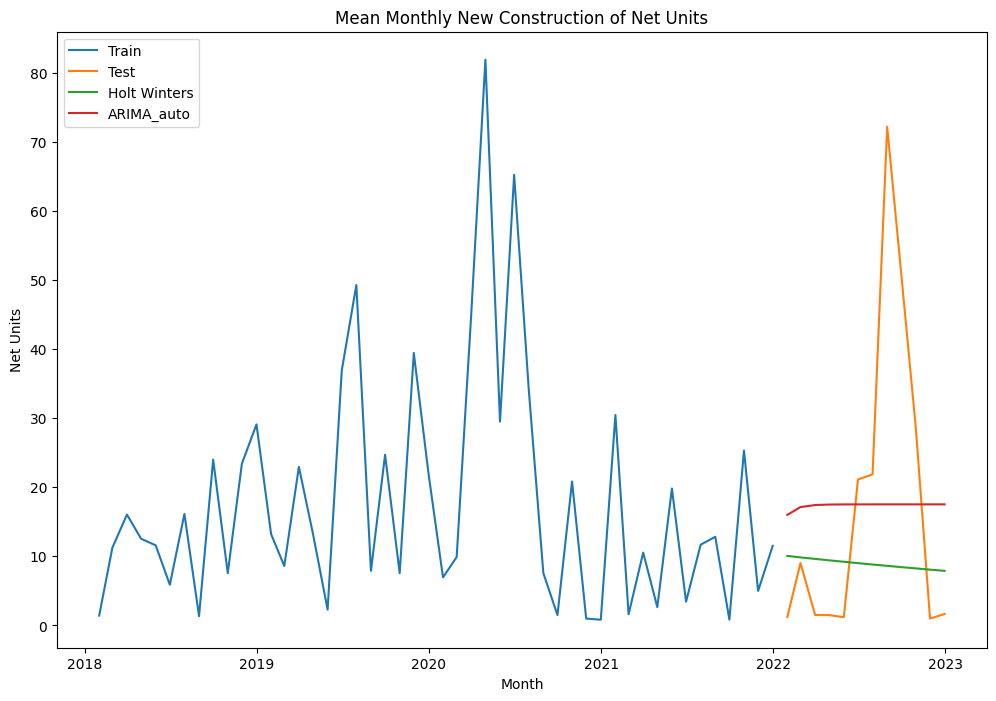

In [841]:
# graphs the train and test data with Holt Winters and SARIMA
plt.figure(figsize = (12, 8))

plt.plot(train.index, train['unitsnet'], label = 'Train')
plt.plot(test.index, test['unitsnet'], label = 'Test')
plt.plot(units_preds.index, units_preds['hw'], label = 'Holt Winters')
plt.plot(units_preds['sarima_auto'], label = 'ARIMA_auto')
plt.legend(loc = 'best')
plt.xlabel('Month')
plt.ylabel('Net Units')
plt.title('Mean Monthly New Construction of Net Units');

In [842]:
mean_squared_error(test['unitsnet'], units_preds['sarima_auto'], squared = False)

22.03995865728176

According to the results of our ARIMA model, only one lag is being used with zero differencing. Again, this makes sense based on what we saw in the Augmented Dickey-Fuller test which showed sufficient stationarity, indicating no need for differencing. However, this ARIMA model is still a poor fit for future prediction of net units. We have a RMSE of ~22.04 net units which is performing only slightly better than our RMSE of our historical mean null model. We can presume that this ARIMA model may be the best fit only slightly in comparison to the null model. We shall now train the same times series models on our net affordable units and see if these model fare any better in predicting net affordable units' new construction.

In [843]:
# create a train test split
train, test = train_test_split(constr_bestdate_monthly[['affordablenet']],
                                                    test_size = 0.2,
                                                    shuffle = False)

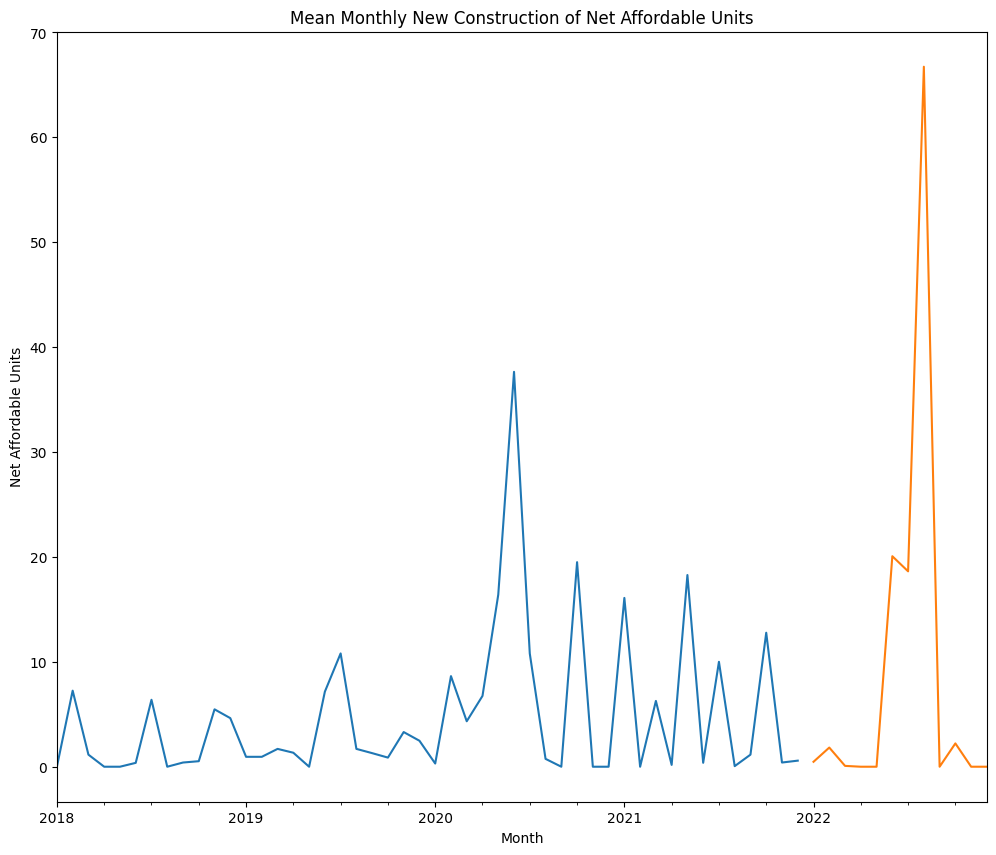

In [844]:
# displays graph of train and test data for net units
train['affordablenet'].plot()
test['affordablenet'].plot(figsize = (12, 10), 
                           xlabel = 'Month',
                           ylabel = 'Net Affordable Units',
                           title = 'Mean Monthly New Construction of Net Affordable Units');

In [845]:
# creates a prediction data frame which is a copy of the test data
affordable_preds = test.copy()

affordable_preds

,affordablenet
bestdate,
2022-01-31,0.470588
2022-02-28,1.826087
2022-03-31,0.080000
2022-04-30,0.000000
2022-05-31,0.000000
2022-06-30,20.066667
2022-07-31,18.625000
2022-08-31,66.727273
2022-09-30,0.000000


In [846]:
# creates a prediction column based on the last value in the train dataset
affordable_preds['last'] = train['affordablenet'][-1]

affordable_preds

,affordablenet,last
bestdate,,
2022-01-31,0.470588,0.578947
2022-02-28,1.826087,0.578947
2022-03-31,0.080000,0.578947
2022-04-30,0.000000,0.578947
2022-05-31,0.000000,0.578947
2022-06-30,20.066667,0.578947
2022-07-31,18.625000,0.578947
2022-08-31,66.727273,0.578947
2022-09-30,0.000000,0.578947


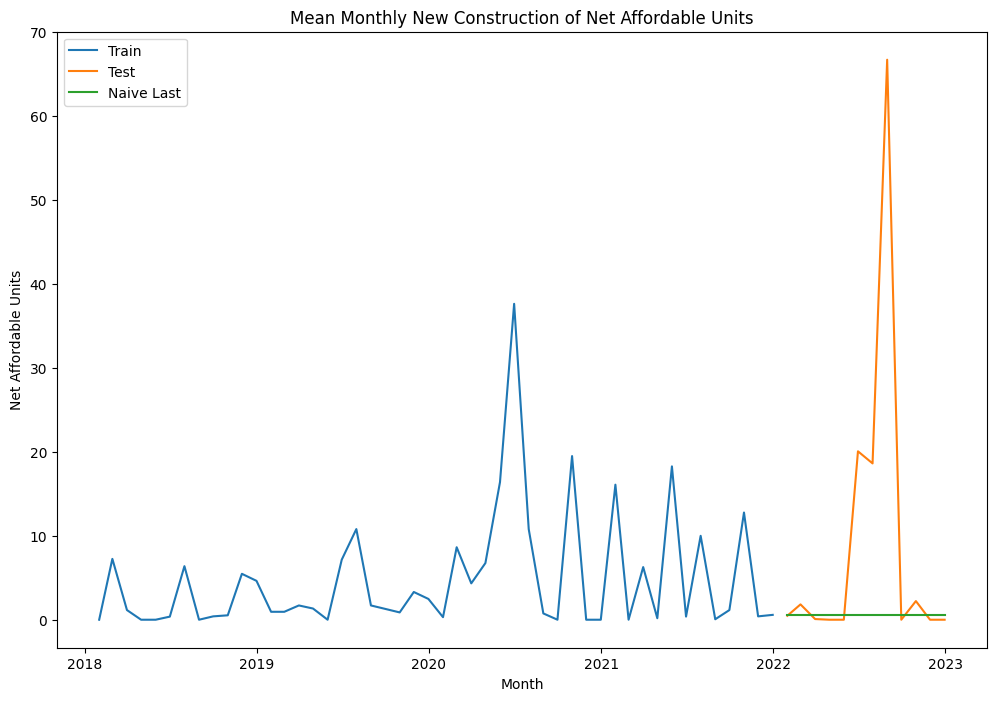

In [847]:
# displays the graph of the train, test and naive last data
plt.figure(figsize = (12, 8))

plt.plot(train.index, train['affordablenet'], label = 'Train')
plt.plot(test.index, test['affordablenet'], label = 'Test')
plt.plot(affordable_preds.index, affordable_preds['last'], label = 'Naive Last')

plt.legend(loc = 'best')
plt.xlabel('Month')
plt.ylabel('Net Affordable Units')
plt.title('Mean Monthly New Construction of Net Affordable Units');

In [848]:
# shows the root mean squared error for the naive last prediction
mean_squared_error(affordable_preds['affordablenet'], affordable_preds['last'], squared = False)

20.58969092098837

In [849]:
# creates a column the simple mean based on the training historical mean
affordable_preds['simple_mean'] = train['affordablenet'].mean()

affordable_preds.head()

,affordablenet,last,simple_mean
bestdate,,,
2022-01-31,0.470588,0.578947,4.790538
2022-02-28,1.826087,0.578947,4.790538
2022-03-31,0.080000,0.578947,4.790538
2022-04-30,0.000000,0.578947,4.790538
2022-05-31,0.000000,0.578947,4.790538


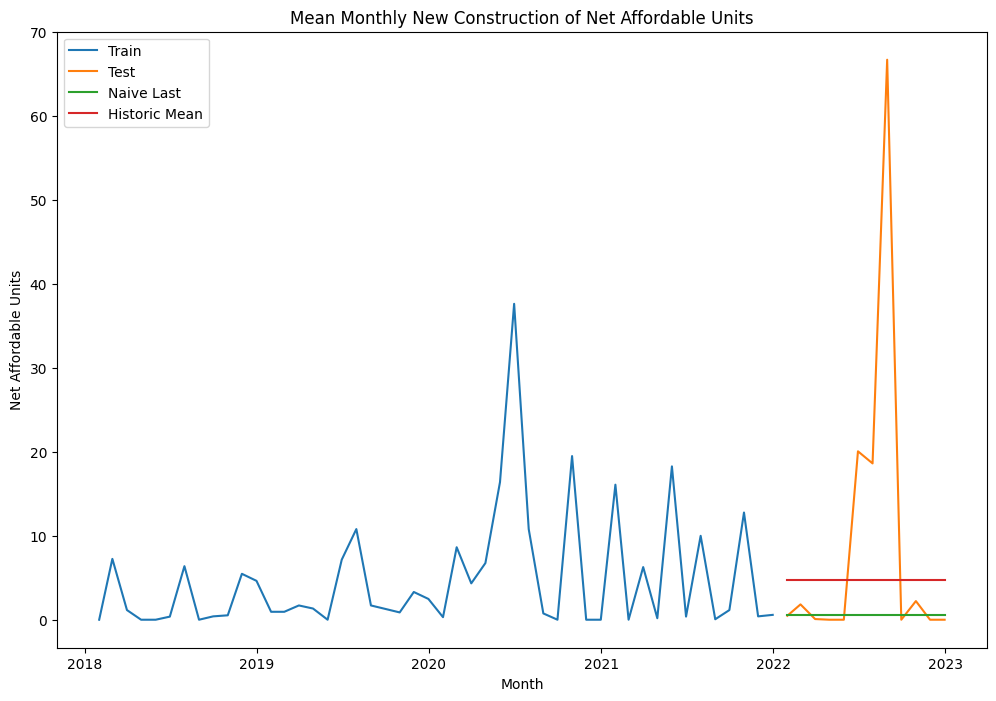

In [850]:
# graphs the train and test data with both the naive last and historic mean
plt.figure(figsize = (12, 8))

plt.plot(train.index, train['affordablenet'], label = 'Train')
plt.plot(test.index, test['affordablenet'], label = 'Test')
plt.plot(units_preds.index, affordable_preds['last'], label = 'Naive Last')
plt.plot(units_preds.index, affordable_preds['simple_mean'], label = 'Historic Mean')

plt.legend(loc = 'best')
plt.xlabel('Month')
plt.ylabel('Net Affordable Units')
plt.title('Mean Monthly New Construction of Net Affordable Units');

In [851]:
# shows the root mean squared error for the historical mean
mean_squared_error(affordable_preds['affordablenet'], affordable_preds['simple_mean'], squared = False)

19.217815455669886

Looking at the null models, the naive last has a RMSE of ~20.59 net affordable units while the historic mean has a RMSE of ~19.22 net affordable units, indicating that the historic mean null model performs slightly better. As before with the net units, we shall try two exponential smoothing models for comparison to see that can outperform the historic mean null model.

In [852]:
# fit a simple exponential smoothing model
simexp = SimpleExpSmoothing(train['affordablenet']).fit(smoothing_level = .5, optimized = False)

In [853]:
# shows a summary of the exponential smoothing
simexp.summary()

Dep. Variable:,affordablenet,No. Observations:,48
Model:,SimpleExpSmoothing,SSE,3017.090
Optimized:,False,AIC,202.761
Trend:,None,BIC,206.503
Seasonal:,None,AICC,203.691
Seasonal Periods:,None,Date:,"Sat, 16 Sep 2023"
Box-Cox:,False,Time:,16:08:38
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.5000000,alpha,False
initial_level,0.000000,l.0,False


In [854]:
# adds the simple exponential smoothing forecast to the predictions
affordable_preds['simexp'] = simexp.forecast(len(test))

affordable_preds

,affordablenet,last,simple_mean,simexp
bestdate,,,,
2022-01-31,0.470588,0.578947,4.790538,2.301367
2022-02-28,1.826087,0.578947,4.790538,2.301367
2022-03-31,0.080000,0.578947,4.790538,2.301367
2022-04-30,0.000000,0.578947,4.790538,2.301367
2022-05-31,0.000000,0.578947,4.790538,2.301367
2022-06-30,20.066667,0.578947,4.790538,2.301367
2022-07-31,18.625000,0.578947,4.790538,2.301367
2022-08-31,66.727273,0.578947,4.790538,2.301367
2022-09-30,0.000000,0.578947,4.790538,2.301367


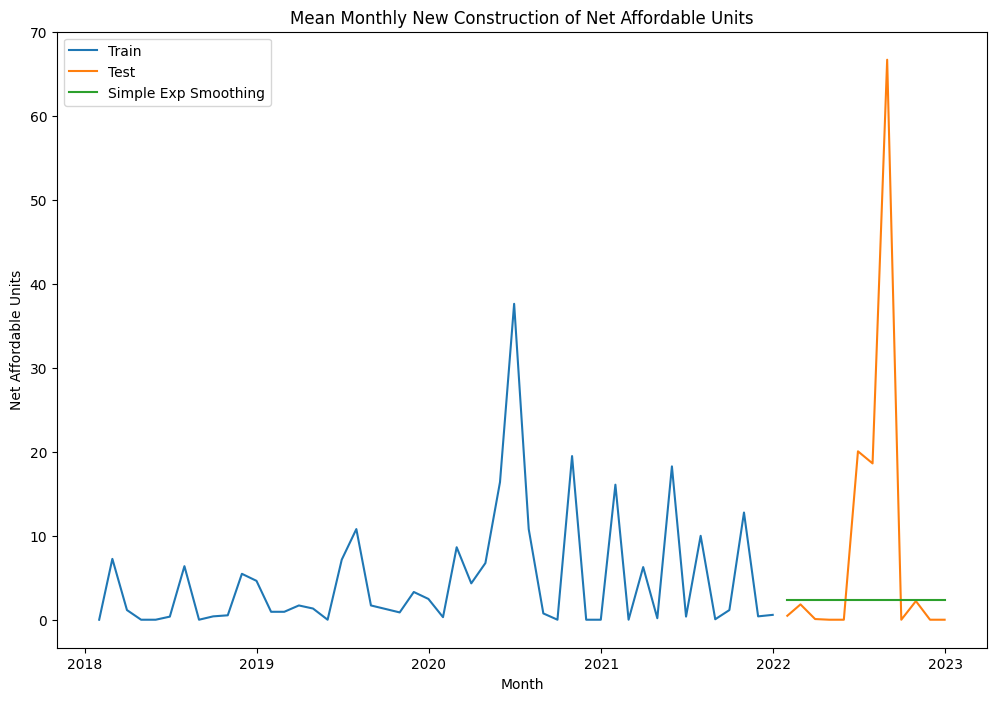

In [855]:
# graphs the train and test data with both the naive last and historic mean
plt.figure(figsize = (12, 8))

plt.plot(train.index, train['affordablenet'], label = 'Train')
plt.plot(test.index, test['affordablenet'], label = 'Test')
plt.plot(units_preds.index, affordable_preds['simexp'], label = 'Simple Exp Smoothing')

plt.legend(loc = 'best')
plt.xlabel('Month')
plt.ylabel('Net Affordable Units')
plt.title('Mean Monthly New Construction of Net Affordable Units');

In [856]:
# shows the root mean squared error for the historical mean
mean_squared_error(affordable_preds['affordablenet'], affordable_preds['simexp'], squared = False)

19.932728611128162

In [857]:
hw = ExponentialSmoothing(train['affordablenet'],
                         trend = 'add').fit()

In [858]:
hw.summary()

Dep. Variable:,affordablenet,No. Observations:,48
Model:,ExponentialSmoothing,SSE,2336.158
Optimized:,True,AIC,194.483
Trend:,Additive,BIC,201.968
Seasonal:,None,AICC,196.532
Seasonal Periods:,None,Date:,"Sat, 16 Sep 2023"
Box-Cox:,False,Time:,16:08:39
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,1.7437e-08,alpha,True
smoothing_trend,1.9997e-10,beta,True


In [859]:
affordable_preds['hw'] = hw.forecast(len(test))

affordable_preds

,affordablenet,last,simple_mean,simexp,hw
bestdate,,,,,
2022-01-31,0.470588,0.578947,4.790538,2.301367,7.643000
2022-02-28,1.826087,0.578947,4.790538,2.301367,7.759428
2022-03-31,0.080000,0.578947,4.790538,2.301367,7.875855
2022-04-30,0.000000,0.578947,4.790538,2.301367,7.992282
2022-05-31,0.000000,0.578947,4.790538,2.301367,8.108709
2022-06-30,20.066667,0.578947,4.790538,2.301367,8.225136
2022-07-31,18.625000,0.578947,4.790538,2.301367,8.341563
2022-08-31,66.727273,0.578947,4.790538,2.301367,8.457990
2022-09-30,0.000000,0.578947,4.790538,2.301367,8.574418


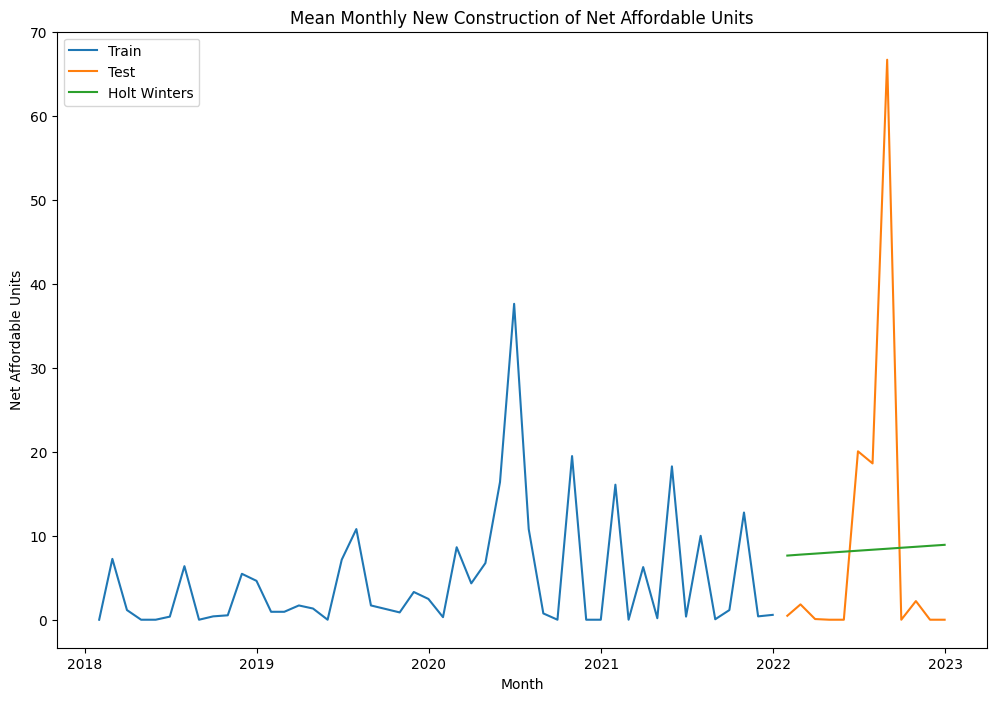

In [860]:
# graphs the train and test data with both the naive last and historic mean
plt.figure(figsize = (12, 8))

plt.plot(train.index, train['affordablenet'], label = 'Train')
plt.plot(test.index, test['affordablenet'], label = 'Test')
plt.plot(affordable_preds.index, affordable_preds['hw'], label = 'Holt Winters')

plt.legend(loc = 'best')
plt.xlabel('Month')
plt.ylabel('Net Affordable Units')
plt.title('Mean Monthly New Construction of Net Affordable Units');

In [861]:
# shows the root mean squared error for the historical mean
mean_squared_error(affordable_preds['affordablenet'], affordable_preds['hw'], squared = False)

18.687998459207744

In [862]:
model = pmd.auto_arima(train['affordablenet'], trace = True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=329.201, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=330.558, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=330.548, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=344.956, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=332.548, Time=0.01 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.100 seconds


In [863]:
model

ARIMA(order=(0, 0, 0), scoring_args={}, suppress_warnings=True)

In [864]:
model.predict()

2022-01-31    4.790538
2022-02-28    4.790538
2022-03-31    4.790538
2022-04-30    4.790538
2022-05-31    4.790538
2022-06-30    4.790538
2022-07-31    4.790538
2022-08-31    4.790538
2022-09-30    4.790538
2022-10-31    4.790538
Freq: M, dtype: float64

In [865]:
affordable_preds['sarima_auto'] = model.predict(test.shape[0])

In [866]:
affordable_preds

,affordablenet,last,simple_mean,simexp,hw,sarima_auto
bestdate,,,,,,
2022-01-31,0.470588,0.578947,4.790538,2.301367,7.643000,4.790538
2022-02-28,1.826087,0.578947,4.790538,2.301367,7.759428,4.790538
2022-03-31,0.080000,0.578947,4.790538,2.301367,7.875855,4.790538
2022-04-30,0.000000,0.578947,4.790538,2.301367,7.992282,4.790538
2022-05-31,0.000000,0.578947,4.790538,2.301367,8.108709,4.790538
2022-06-30,20.066667,0.578947,4.790538,2.301367,8.225136,4.790538
2022-07-31,18.625000,0.578947,4.790538,2.301367,8.341563,4.790538
2022-08-31,66.727273,0.578947,4.790538,2.301367,8.457990,4.790538
2022-09-30,0.000000,0.578947,4.790538,2.301367,8.574418,4.790538


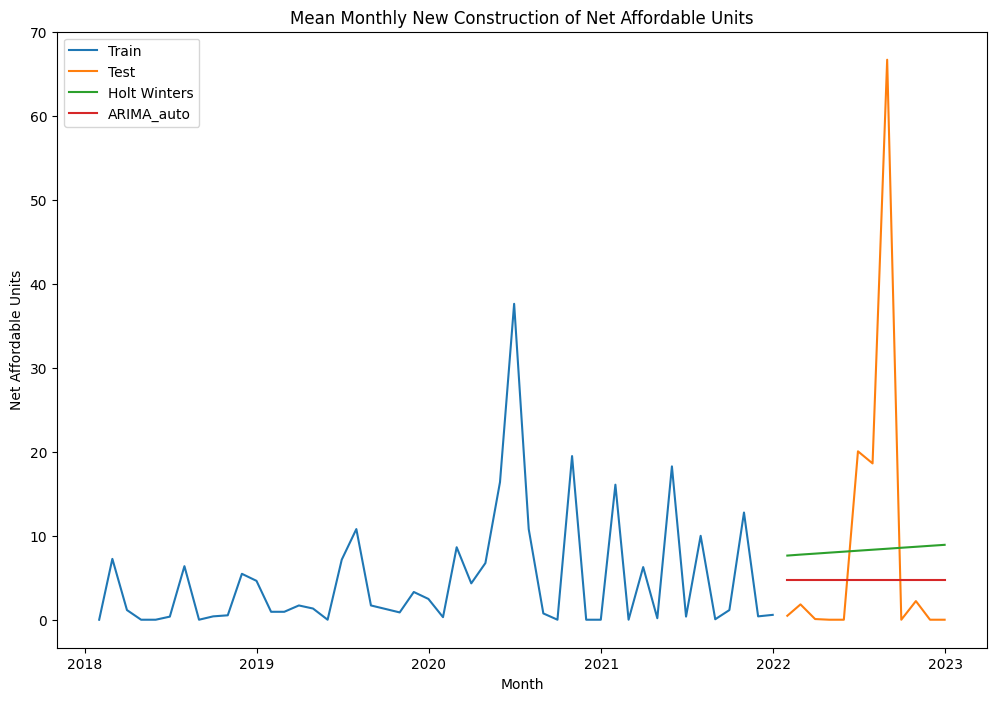

In [867]:
# graphs the train and test data with both the naive last and historic mean
plt.figure(figsize = (12, 8))

plt.plot(train.index, train['affordablenet'], label = 'Train')
plt.plot(test.index, test['affordablenet'], label = 'Test')
plt.plot(affordable_preds.index, affordable_preds['hw'], label = 'Holt Winters')
plt.plot(affordable_preds['sarima_auto'], label = 'ARIMA_auto')
plt.legend(loc = 'best')
plt.xlabel('Month')
plt.ylabel('Net Affordable Units')
plt.title('Mean Monthly New Construction of Net Affordable Units');

In [868]:
mean_squared_error(test['affordablenet'], affordable_preds['sarima_auto'], squared = False )

19.217815455669886

We now have two exponential smoothing models and our ARIMA model for comparison in their performance. Looking at the simple exponential smoothing model first, it appears that this model has a RMSE of ~19.93 net affordable units. This is slightly better than our naive last null model, but does not perform better than the historic mean. Next, we have our Holt Winters model with a RMSE of ~18.69 net affordable units. This is outperforming our historic mean predictions and the simple exponential smoothing model but only a bit. The Holt Winters is also a better fit than simple exponential smoothing with an AIC score of ~194 in comparison to ~203. Lastly, the ARIMA model with the best fit showed zero lags and zero differences in fitting, meaning that the best fit was technically not even an autocorrelation. With an RMSE of ~19.22 net affordable units, this error was identical to the null historic mean and upon inspecting both predictions we can we that they are all identical. Therefore, the ARIMA model is pointing to the fact that any number of lags or differencing would perform no better than merely predicting the historic mean, indicating that the future construction is nearly impossible to predict from past construction. Although Holt Winters performs somewhat better at the end of the day this only narrowly smaller margin of error tells us the we can weight more recent values in time to get a minor improvement in predictive performance.

Our last attempt to make an accurate prediction now will be based on using a vector autoregression (VAR) with both net units and net affordable units. Since these two variables are likely highly correlated as we saw in our exploratory data analysis, a VAR model may prove best for making future predictions. Since our Augmented Dickey-Fuller test showed that we can accept stationarity in both variables over time, we can presume that no differencing is required in training our vector autoregression models. This was also corroborated in our auto-ARIMA models above in which net units used only one lag and no differencing and net affordable units used zero lags and zero differencing.

In [869]:
# display the correlations between variables
constr_bestdate_monthly.corr()

,unitsnet,affordablenet
unitsnet,1.000000,0.624362
affordablenet,0.624362,1.000000


In [870]:
# create a train test split for both variables
train, test = train_test_split(constr_bestdate_monthly,
                               test_size = 0.20,
                               shuffle = False)

In [871]:
# instantiate a VAR model.
model = VAR(maxlags = 15, verbose = True)

In [872]:
# fit our model on the train data
model.fit(train)

VAR(maxlags=15, verbose=True)

In [873]:
# make a data frame of predictions
preds = model.predict(test.index)

preds

,unitsnet,affordablenet
bestdate,,
2022-01-31,-153.905711,-78.088511
2022-02-28,-162.914837,-72.535064
2022-03-31,-184.694676,-173.791105
2022-04-30,-16.832185,-147.126825
2022-05-31,-163.558589,-197.152001
2022-06-30,-35.695163,-191.259518
2022-07-31,56.303280,-224.224901
2022-08-31,210.250779,-278.161468
2022-09-30,416.743367,-215.058619


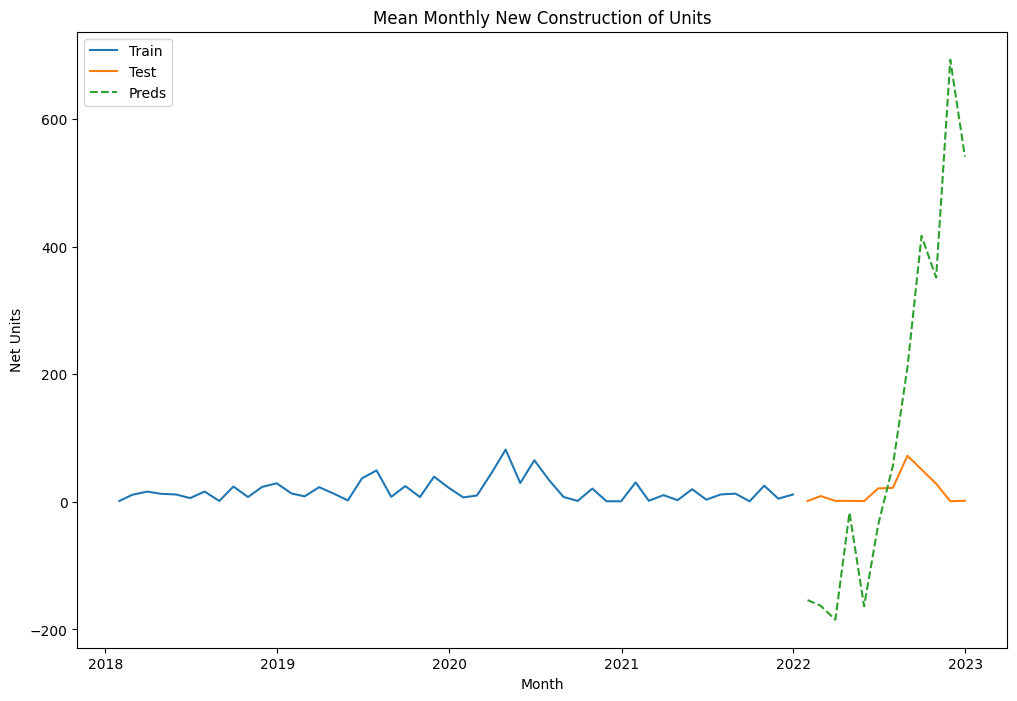

In [874]:
# plot net units train, test, and predictions
plt.figure(figsize = (12, 8))
plt.plot(train['unitsnet'], label = 'Train')
plt.plot(test['unitsnet'], label = 'Test')
plt.plot(preds['unitsnet'], label = 'Preds', linestyle = '--')
plt.xlabel('Month')
plt.ylabel('Net Units')
plt.title('Mean Monthly New Construction of Units')
plt.legend();

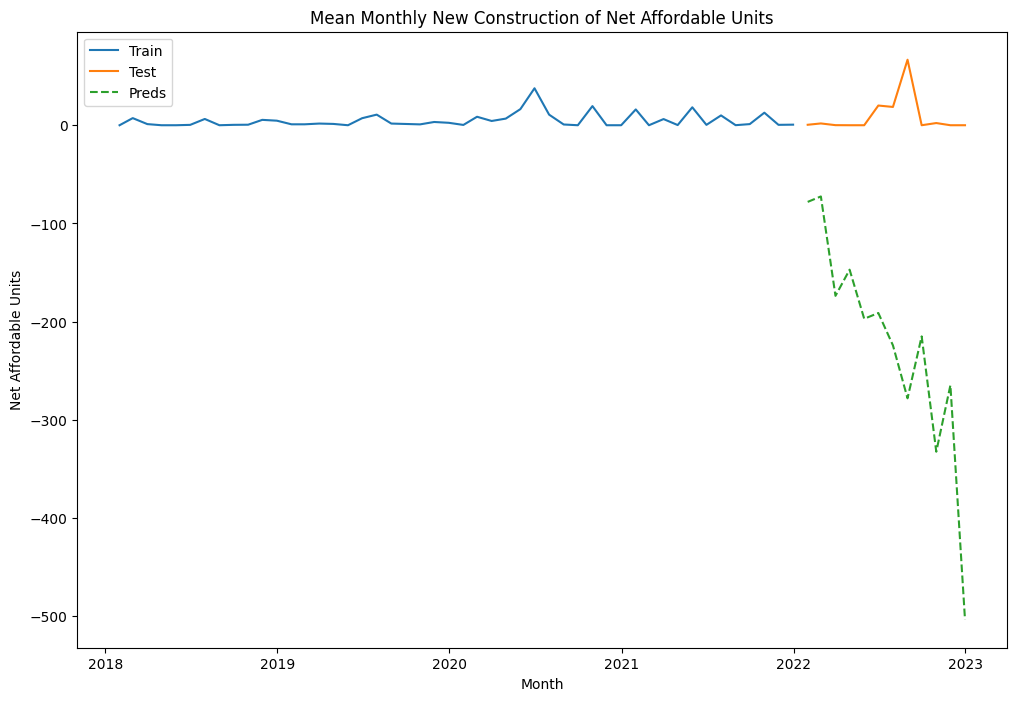

In [875]:
# plot net affordable units train, test, and predictions
plt.figure(figsize = (12, 8))
plt.plot(train['affordablenet'], label = 'Train')
plt.plot(test['affordablenet'], label = 'Test')
plt.plot(preds['affordablenet'], label = 'Preds', linestyle = '--')
plt.xlabel('Month')
plt.ylabel('Net Affordable Units')
plt.title('Mean Monthly New Construction of Net Affordable Units')
plt.legend();

In [876]:
# loop through both columns in test and print the RMSE of both variables' predictions
for i in range(test.shape[1]):
    print(f'The test RMSE on the {test.columns[i]} data is: {round(mean_squared_error(test.values[:, i], preds.iloc[:, i], squared = False), 4)}')

The test RMSE on the unitsnet data is: 309.1996
The test RMSE on the affordablenet data is: 259.3548


Despite the fact that our two variable are somewhat correlated with a correlation coefficient of ~0.62, this vector autoregression model perform very poorly on both variables, far more poorly than either of our naive last null models. As stated earlier regarding our ARIMA model on net affordable units which just used the historic mean, we can merely conclude that prior construction is a poor predictor of future construction, meaning a time series in model may not serve us in predicting new construction.

We shall see if these same shortcomings are true now for predicting net units and affordable units in the development pipeline in any given quarter. First, we shall make a new data frame with the index based on quarter and then resample each quarter according to the sum. Then we shall begin time series modeling on both net unnits and net affordable units as we had previously on new construction.

In [877]:
# make a date frame for preprocessing with bestdate index
constr_qtr = constr.copy()

In [878]:
# set index to bestdate
constr_qtr.set_index('yearqtr', inplace = True)

constr_qtr

,beststat,bestdate,unitsnet,affordablenet
yearqtr,,,,
2022-12-31,CONSTRUCTION,2021-09-20 11:44:06,1.0,0.0
2022-12-31,CONSTRUCTION,2019-07-26 00:00:00,0.0,0.0
2022-12-31,CONSTRUCTION,2021-10-20 11:10:35,1.0,0.0
2022-12-31,CONSTRUCTION,2019-10-07 00:00:00,1.0,0.0
2022-12-31,CONSTRUCTION,2019-10-09 00:00:00,1.0,0.0
...,...,...,...,...
2018-03-31,CONSTRUCTION,2018-02-02 00:00:00,0.0,0.0
2018-03-31,CONSTRUCTION,2018-04-04 00:00:00,0.0,0.0
2018-03-31,CONSTRUCTION,2018-01-04 00:00:00,0.0,0.0


In [879]:
# sort index according to datetime
constr_qtr.sort_index(inplace = True)

constr_qtr

,beststat,bestdate,unitsnet,affordablenet
yearqtr,,,,
2018-03-31,CONSTRUCTION,2018-03-08 00:00:00,0.0,0.0
2018-03-31,CONSTRUCTION,2018-03-20 00:00:00,3.0,0.0
2018-03-31,CONSTRUCTION,2018-04-13 00:00:00,1.0,0.0
2018-03-31,CONSTRUCTION,2018-02-09 00:00:00,2.0,0.0
2018-03-31,CONSTRUCTION,2018-03-30 00:00:00,3.0,0.0
...,...,...,...,...
2022-12-31,CONSTRUCTION,2020-04-02 00:00:00,1.0,0.0
2022-12-31,CONSTRUCTION,2022-06-02 08:26:15,0.0,0.0
2022-12-31,CONSTRUCTION,2022-01-03 00:00:00,1.0,0.0


In [880]:
# drop the bestdate and beststat columns
constr_qtr.drop(columns = ['bestdate', 'beststat'], inplace = True)

In [881]:
# preview data frame
constr_qtr

,unitsnet,affordablenet
yearqtr,,
2018-03-31,0.0,0.0
2018-03-31,3.0,0.0
2018-03-31,1.0,0.0
2018-03-31,2.0,0.0
2018-03-31,3.0,0.0
...,...,...
2022-12-31,1.0,0.0
2022-12-31,0.0,0.0
2022-12-31,1.0,0.0


In [882]:
# preview data frame grouped according to year and quarter index
constr_qtr.groupby('yearqtr')[['unitsnet', 'affordablenet']].sum()

,unitsnet,affordablenet
yearqtr,,
2018-03-31,6748.0,1653.0
2018-06-30,7078.0,2330.0
2018-09-30,7460.0,2267.0
2018-12-31,8073.0,2184.0
2019-03-31,8500.0,2153.0
2019-06-30,9894.0,2875.0
2019-09-30,9430.0,1791.0
2019-12-31,10198.0,2411.0
2020-03-31,9632.0,2230.0


In [883]:
# resamples data on a summed quarterly basis 
constr_qtr = constr_qtr.resample('Q').sum()

constr_qtr.head()

,unitsnet,affordablenet
yearqtr,,
2018-03-31,6748.0,1653.0
2018-06-30,7078.0,2330.0
2018-09-30,7460.0,2267.0
2018-12-31,8073.0,2184.0
2019-03-31,8500.0,2153.0


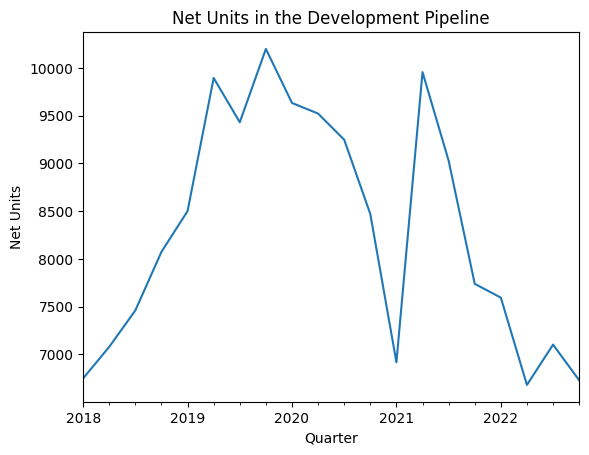

In [884]:
# displays line plot of net units in the development pipeline
constr_qtr['unitsnet'].plot(xlabel = 'Quarter', 
                            ylabel = 'Net Units', 
                            title = 'Net Units in the Development Pipeline');

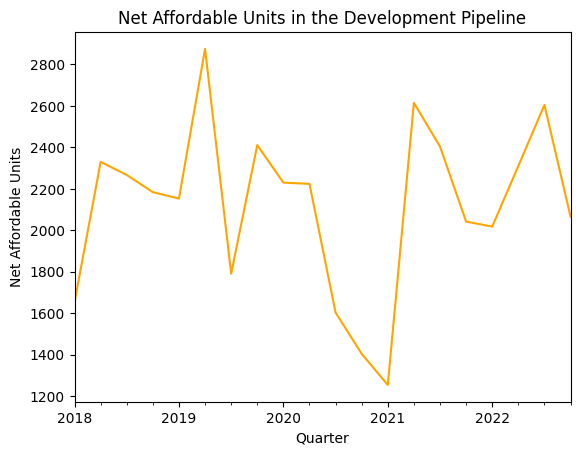

In [885]:
# displays line plot of net affordable units in the development pipeline
constr_qtr['affordablenet'].plot(xlabel = 'Quarter', 
                                 ylabel = 'Net Affordable Units', 
                                 title = 'Net Affordable Units in the Development Pipeline',
                                 color = 'orange');

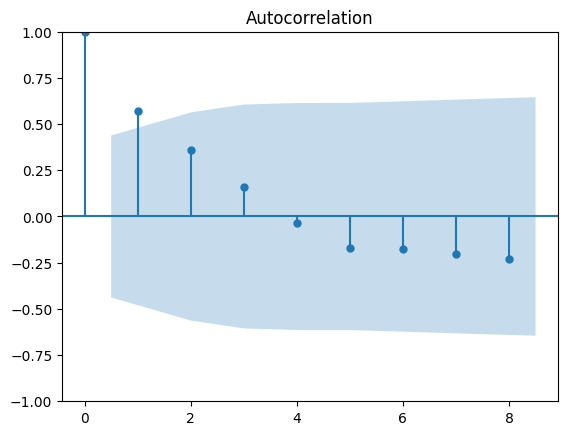

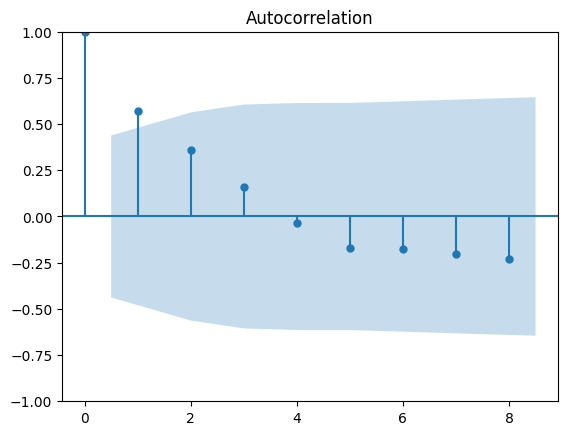

In [886]:
# plots autocorrelation for net units over 8 lags (2 years)
plot_acf(constr_qtr['unitsnet'], lags = 8)

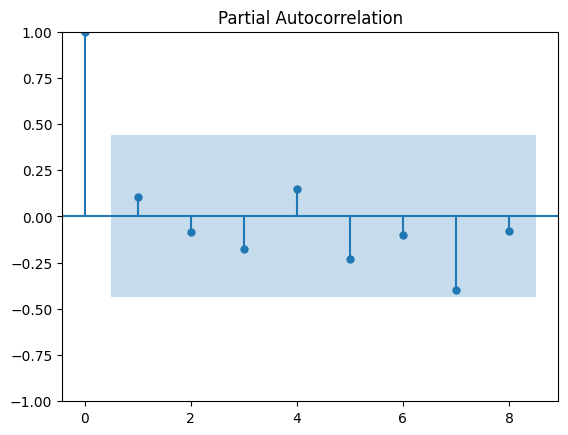

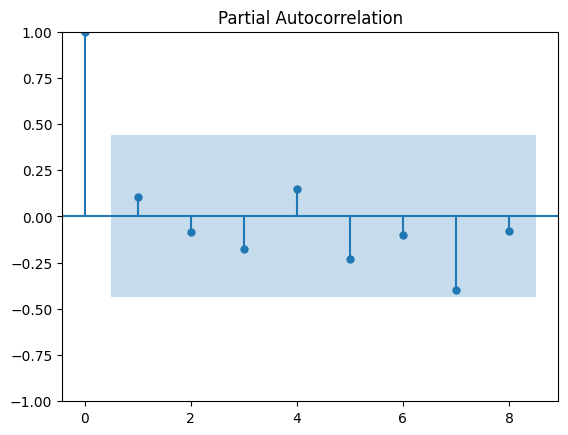

In [887]:
# plots autocorrelation for net units over 8 lags (2 years)
plot_pacf(constr_qtr['affordablenet'], lags = 8)

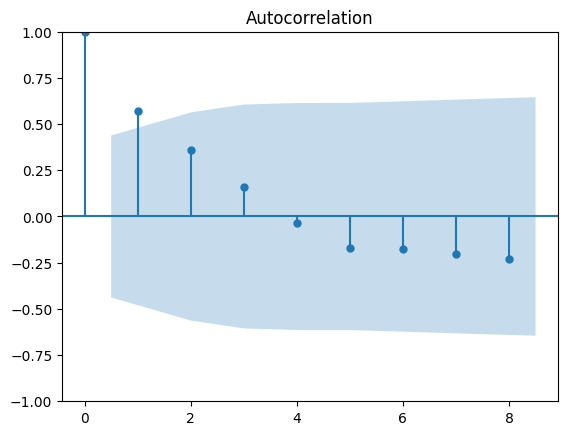

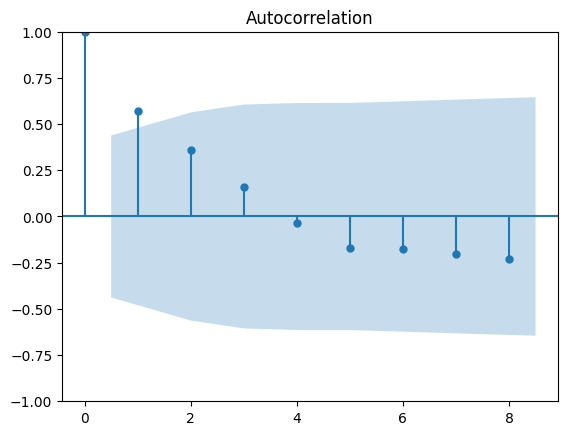

In [888]:
# plots autocorrelation for net units over 8 lags (2 years)
plot_acf(constr_qtr['unitsnet'], lags = 8)

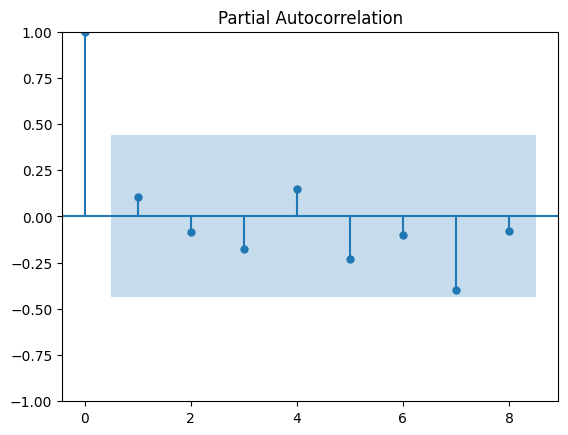

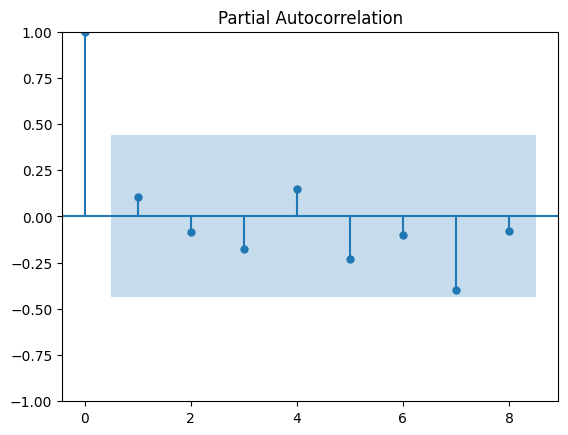

In [889]:
# plots autocorrelation for net units over 8 lags (2 years)
plot_pacf(constr_qtr['affordablenet'], lags = 8)

In [890]:
# Run ADF test on the net units
interpret_dftest(adfuller(constr_qtr['unitsnet']))

,0
Test Statistic,-0.438747
p-value,0.903426
Lag Used,8.000000


In [891]:
# Run ADF test on the net units
interpret_dftest(adfuller(constr_qtr['affordablenet']))

,0
Test Statistic,-0.836802
p-value,0.808072
Lag Used,7.000000


Based on our cursory exploratory data analysis, we can see that there appears to be only one lag with a statistically significant autocorrelation for both the net units and net affordable units. However, this autocorrelation is no longer statistically significant after the partial autocorrelation. This means that we may have even poorer performance on these time series models for the quarterly pipeline data. There is also no sign of seasonality, so we will likely not see this as a feature in our Holt Winters or auto-ARIMA model. Also, according to the Augmented Dickey-Fuller test, we are seeing p-values of ~0.90 for the net units and ~ 0.81 for the net affordable units. Therefore, we will likely see some differencing in our auto-ARIMA models and will also need to conduct some differencing in fitting our vector autoregression models later.

For now, we shall focus on our net units first and fit our null, exponential smoothing, and auto-ARIMA models successively.

In [892]:
# create a train test split
train, test = train_test_split(constr_qtr[['unitsnet']],
                                                    test_size = 0.2,
                                                    shuffle = False)

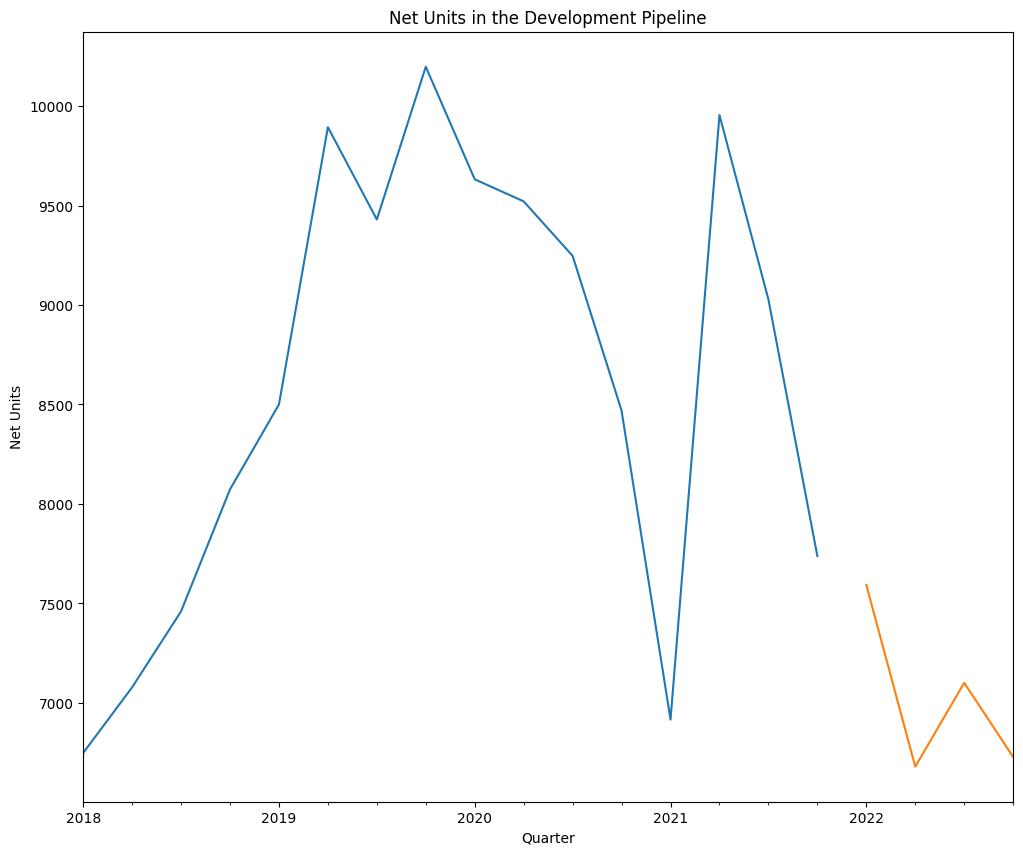

In [893]:
# displays graph of train and test data for net units
train['unitsnet'].plot()
test['unitsnet'].plot(figsize = (12, 10), 
                      xlabel = 'Quarter',
                      ylabel = 'Net Units',
                      title = 'Net Units in the Development Pipeline');

In [894]:
# creates a prediction data frame which is a copy of the test data
u_preds = test.copy()

u_preds

,unitsnet
yearqtr,
2022-03-31,7593.0
2022-06-30,6679.0
2022-09-30,7101.0
2022-12-31,6728.0


In [895]:
# creates a prediction column based on the last value in the train dataset
u_preds['last'] = train['unitsnet'][-1]

u_preds

,unitsnet,last
yearqtr,,
2022-03-31,7593.0,7738.0
2022-06-30,6679.0,7738.0
2022-09-30,7101.0,7738.0
2022-12-31,6728.0,7738.0


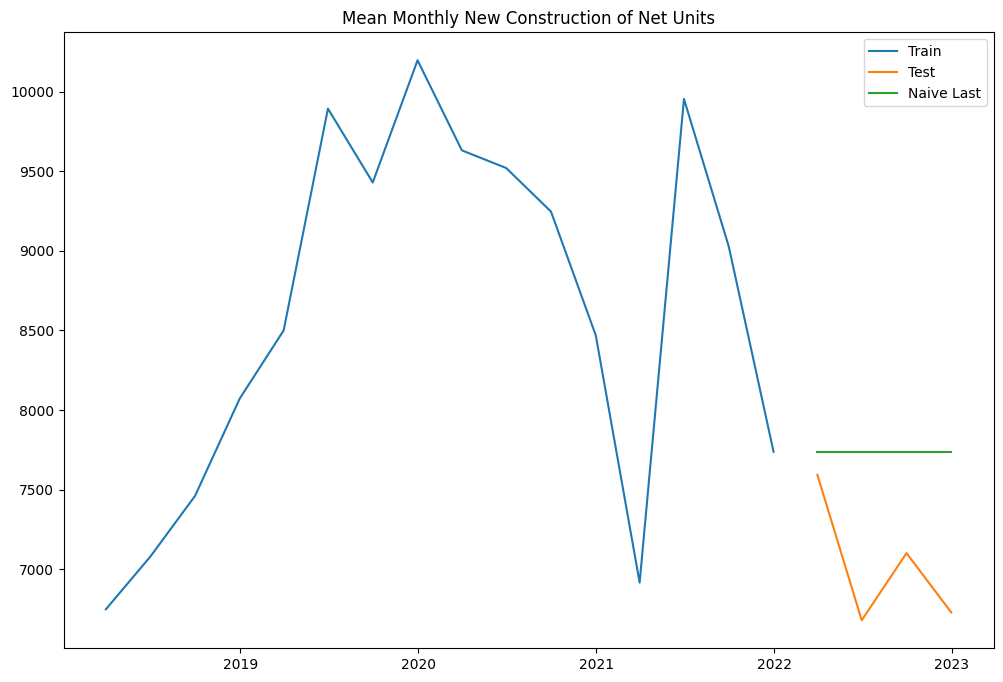

In [896]:
# displays the graph of the train, test and naive last data
plt.figure(figsize = (12, 8))

plt.plot(train.index, train['unitsnet'], label = 'Train')
plt.plot(test.index, test['unitsnet'], label = 'Test')
plt.plot(u_preds.index, u_preds['last'], label = 'Naive Last')

plt.legend(loc = 'best')
plt.title('Mean Monthly New Construction of Net Units');

In [897]:
# shows the root mean squared error for the naive last prediction
mean_squared_error(u_preds['unitsnet'], u_preds['last'], squared = False)

801.3075252360981

In [898]:
# creates a column the simple mean based on the training historical mean
u_preds['simple_mean'] = train['unitsnet'].mean()

u_preds.head()

,unitsnet,last,simple_mean
yearqtr,,,
2022-03-31,7593.0,7738.0,8617.9375
2022-06-30,6679.0,7738.0,8617.9375
2022-09-30,7101.0,7738.0,8617.9375
2022-12-31,6728.0,7738.0,8617.9375


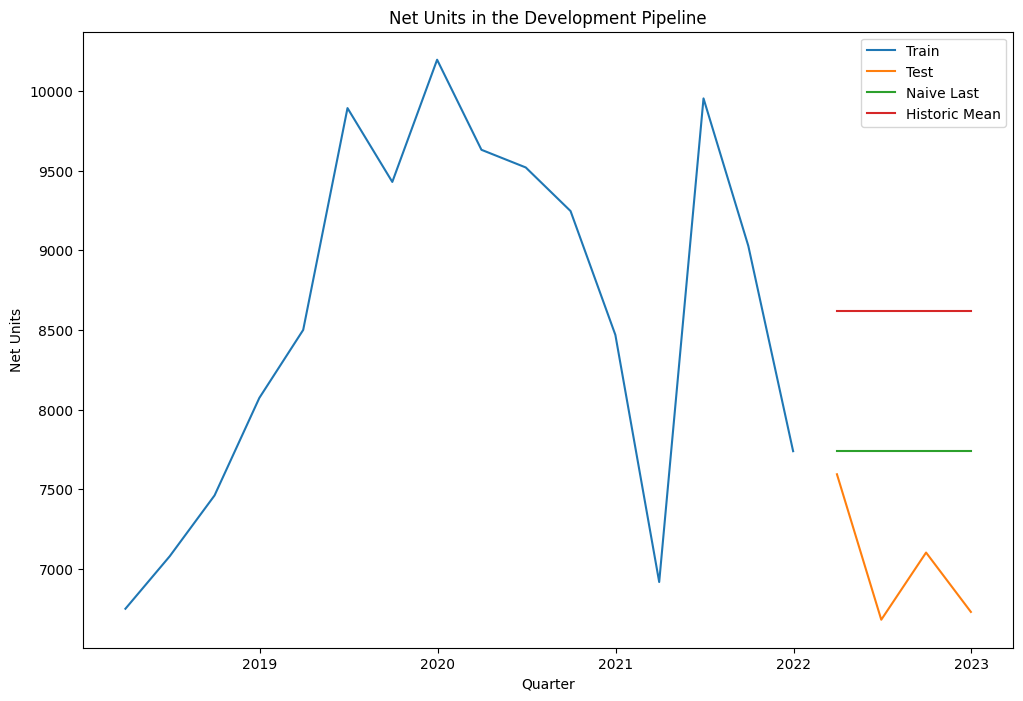

In [899]:
# graphs the train and test data with both the naive last and historic mean
plt.figure(figsize = (12, 8))

plt.plot(train.index, train['unitsnet'], label = 'Train')
plt.plot(test.index, test['unitsnet'], label = 'Test')
plt.plot(u_preds.index, u_preds['last'], label = 'Naive Last')
plt.plot(u_preds.index, u_preds['simple_mean'], label = 'Historic Mean')

plt.legend(loc = 'best')
plt.xlabel('Quarter')
plt.ylabel('Net Units')
plt.title('Net Units in the Development Pipeline');

In [900]:
# shows the root mean squared error for the historical mean
mean_squared_error(u_preds['unitsnet'], u_preds['simple_mean'], squared = False)

1634.2382507322027

According to our two null models, the naive last has a much smaller margin of error than the historic mean, with a RMSE of ~801 net units and ~1634 net units, respectively. Therefore in evaluating our subsequent time series models for net units we shall use the naive last as our baseline.

In [901]:
# fit a simple exponential smoothing model
simexp = SimpleExpSmoothing(train['unitsnet']).fit(smoothing_level = .5, optimized = False)

In [902]:
# shows a summary of the exponential smoothing
simexp.summary()

Dep. Variable:,unitsnet,No. Observations:,16
Model:,SimpleExpSmoothing,SSE,17316155.262
Optimized:,False,AIC,226.313
Trend:,None,BIC,227.858
Seasonal:,None,AICC,229.949
Seasonal Periods:,None,Date:,"Sat, 16 Sep 2023"
Box-Cox:,False,Time:,16:08:48
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.5000000,alpha,False
initial_level,6748.0000,l.0,False


In [903]:
# adds the simple exponential smoothing forecast to the predictions
u_preds['simexp'] = simexp.forecast(len(test))

u_preds

,unitsnet,last,simple_mean,simexp
yearqtr,,,,
2022-03-31,7593.0,7738.0,8617.9375,8361.669373
2022-06-30,6679.0,7738.0,8617.9375,8361.669373
2022-09-30,7101.0,7738.0,8617.9375,8361.669373
2022-12-31,6728.0,7738.0,8617.9375,8361.669373


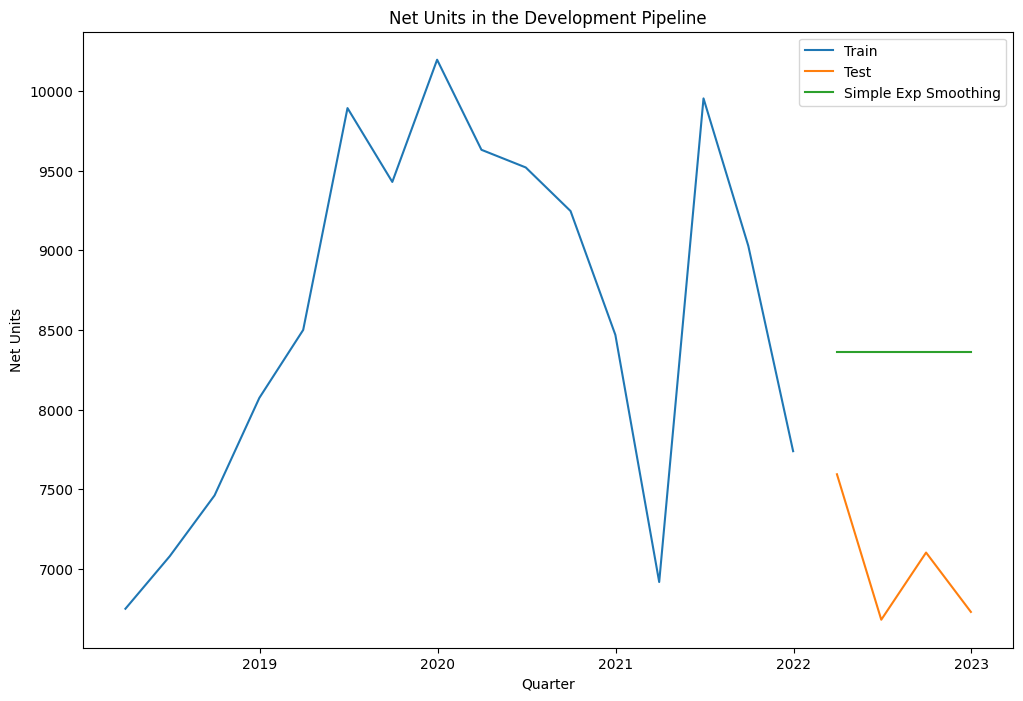

In [904]:
# graphs the train and test data with simple exponential smoothing
plt.figure(figsize = (12, 8))

plt.plot(train.index, train['unitsnet'], label = 'Train')
plt.plot(test.index, test['unitsnet'], label = 'Test')
plt.plot(u_preds.index, u_preds['simexp'], label = 'Simple Exp Smoothing')

plt.legend(loc = 'best')
plt.xlabel('Quarter')
plt.ylabel('Net Units')
plt.title('Net Units in the Development Pipeline');

In [905]:
# shows the root mean squared error for simple exponential smoothing
mean_squared_error(u_preds['unitsnet'], u_preds['simexp'], squared = False)

1385.6759819127649

In [906]:
# fit a Holt Winters model
hw = ExponentialSmoothing(train['unitsnet'],
                         trend = 'add').fit()

In [907]:
# display the summar of Holt Winters
hw.summary()

Dep. Variable:,unitsnet,No. Observations:,16
Model:,ExponentialSmoothing,SSE,17713464.545
Optimized:,True,AIC,230.676
Trend:,Additive,BIC,233.766
Seasonal:,None,AICC,240.009
Seasonal Periods:,None,Date:,"Sat, 16 Sep 2023"
Box-Cox:,False,Time:,16:08:50
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.5707143,alpha,True
smoothing_trend,0.2140179,beta,True


In [908]:
# add a column of Holt Winter predictions to data frame
u_preds['hw'] = hw.forecast(len(test))

u_preds

,unitsnet,last,simple_mean,simexp,hw
yearqtr,,,,,
2022-03-31,7593.0,7738.0,8617.9375,8361.669373,8156.072396
2022-06-30,6679.0,7738.0,8617.9375,8361.669373,8027.418030
2022-09-30,7101.0,7738.0,8617.9375,8361.669373,7898.763664
2022-12-31,6728.0,7738.0,8617.9375,8361.669373,7770.109298


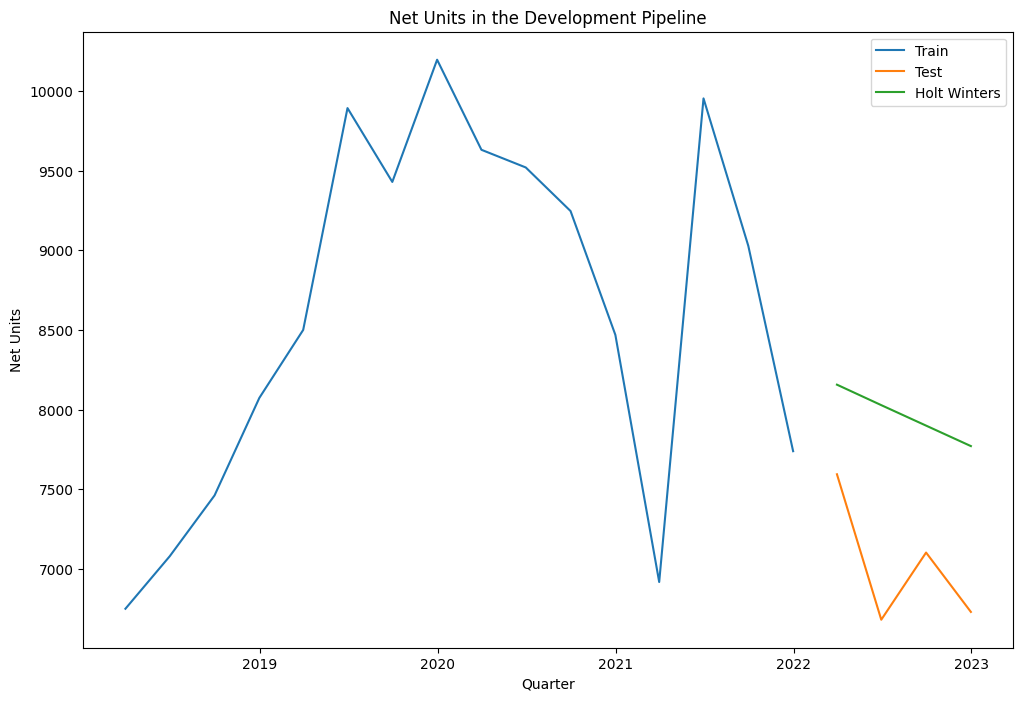

In [909]:
# graphs the train and test data with Holt Winters
plt.figure(figsize = (12, 8))

plt.plot(train.index, train['unitsnet'], label = 'Train')
plt.plot(test.index, test['unitsnet'], label = 'Test')
plt.plot(u_preds.index, u_preds['hw'], label = 'Holt Winters')

plt.legend(loc = 'best')
plt.xlabel('Quarter')
plt.ylabel('Net Units')
plt.title('Net Units in the Development Pipeline');

In [910]:
# shows the root mean squared error for Holt Winters
mean_squared_error(u_preds['unitsnet'], u_preds['hw'], squared = False)

982.0514702365424

In [911]:
# fit the auto-ARIMA model
model = pmd.auto_arima(train['unitsnet'], trace = True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=295.919, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=274.178, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=272.435, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=272.973, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=337.647, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=274.892, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=274.675, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=275.836, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=277.712, Time=0.00 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.178 seconds


In [912]:
# show ARIMA model parameters
model

ARIMA(order=(1, 0, 0), scoring_args={}, suppress_warnings=True)

In [913]:
# show ARIMA model predictions
model.predict()

2022-03-31    8188.124365
2022-06-30    8379.344675
2022-09-30    8460.578240
2022-12-31    8495.087608
2023-03-31    8509.747761
2023-06-30    8515.975638
2023-09-30    8518.621344
2023-12-31    8519.745283
2024-03-31    8520.222751
2024-06-30    8520.425588
Freq: Q-DEC, dtype: float64

In [914]:
# add auto-ARIMA predictions to data frame
u_preds['sarima_auto'] = model.predict(test.shape[0])

In [915]:
u_preds

,unitsnet,last,simple_mean,simexp,hw,sarima_auto
yearqtr,,,,,,
2022-03-31,7593.0,7738.0,8617.9375,8361.669373,8156.072396,8188.124365
2022-06-30,6679.0,7738.0,8617.9375,8361.669373,8027.418030,8379.344675
2022-09-30,7101.0,7738.0,8617.9375,8361.669373,7898.763664,8460.578240
2022-12-31,6728.0,7738.0,8617.9375,8361.669373,7770.109298,8495.087608


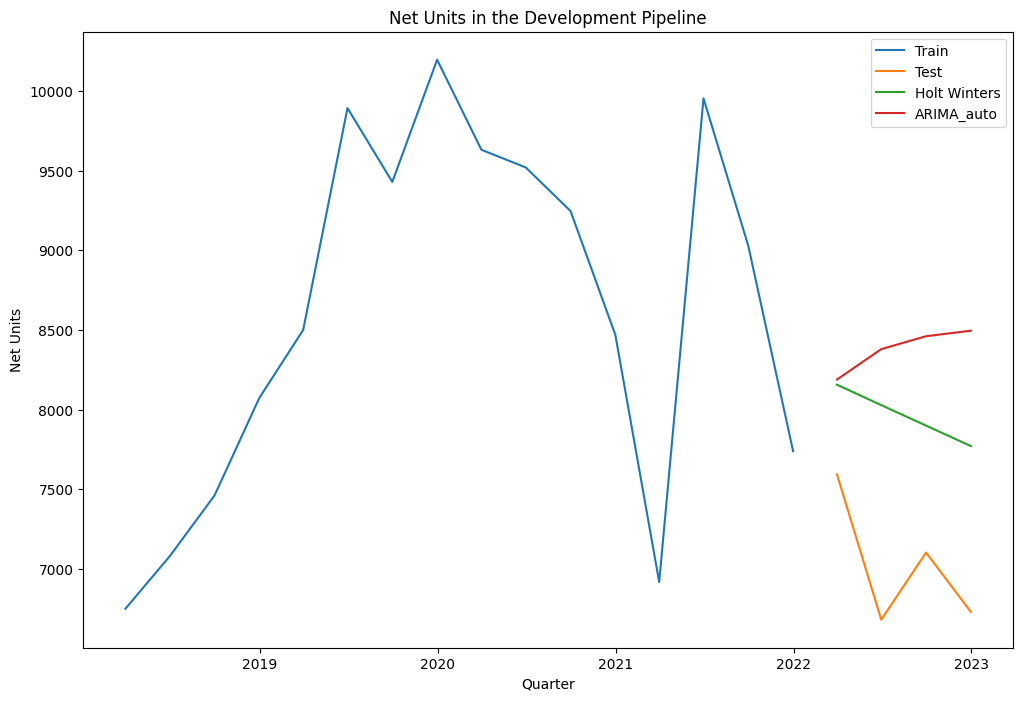

In [916]:
# graphs the train and test data with both the Holt Winters and Auto-ARIMA
plt.figure(figsize = (12, 8))

plt.plot(train.index, train['unitsnet'], label = 'Train')
plt.plot(test.index, test['unitsnet'], label = 'Test')
plt.plot(u_preds.index, u_preds['hw'], label = 'Holt Winters')
plt.plot(u_preds['sarima_auto'], label = 'ARIMA_auto')

plt.xlabel('Quarter')
plt.ylabel('Net Units')
plt.title('Net Units in the Development Pipeline')
plt.legend(loc = 'best');

In [917]:
# shows the root mean squared error for the auto-ARIMA
mean_squared_error(test['unitsnet'], u_preds['sarima_auto'], squared = False)

1433.2128791912876

Looking at the simple exponential, Holt Winters, and auto-ARIMA models, we can see that none of them are performing as well as our naive last null model, according to the root mean squared error metric the simple exponential smoothing model has a RMSE of ~1,386 net units, Holt Winters has a RMSE of ~982 net units, and the ARIMA has a RMSE of ~1,433 net units. As in previous models, our Holt Winters appears to be performing the best albeit still more poorly than our null model. Surprisingly, the auto-ARIMA found the best fit with only one lag and zero differencing. This is in contrast to what we saw with the Augmented Dickey Fuller test earlier in which we had a very high p-value and could not assume stationarity, so we would expect to see some differencing in the auto-ARIMA model to correct for this. It would appear that the model still fits poorly with differencing.

We will now check these time series models one more time against our net affordable units data.

In [918]:
# create a train test split
train, test = train_test_split(constr_qtr[['affordablenet']],
                                                    test_size = 0.2,
                                                    shuffle = False)

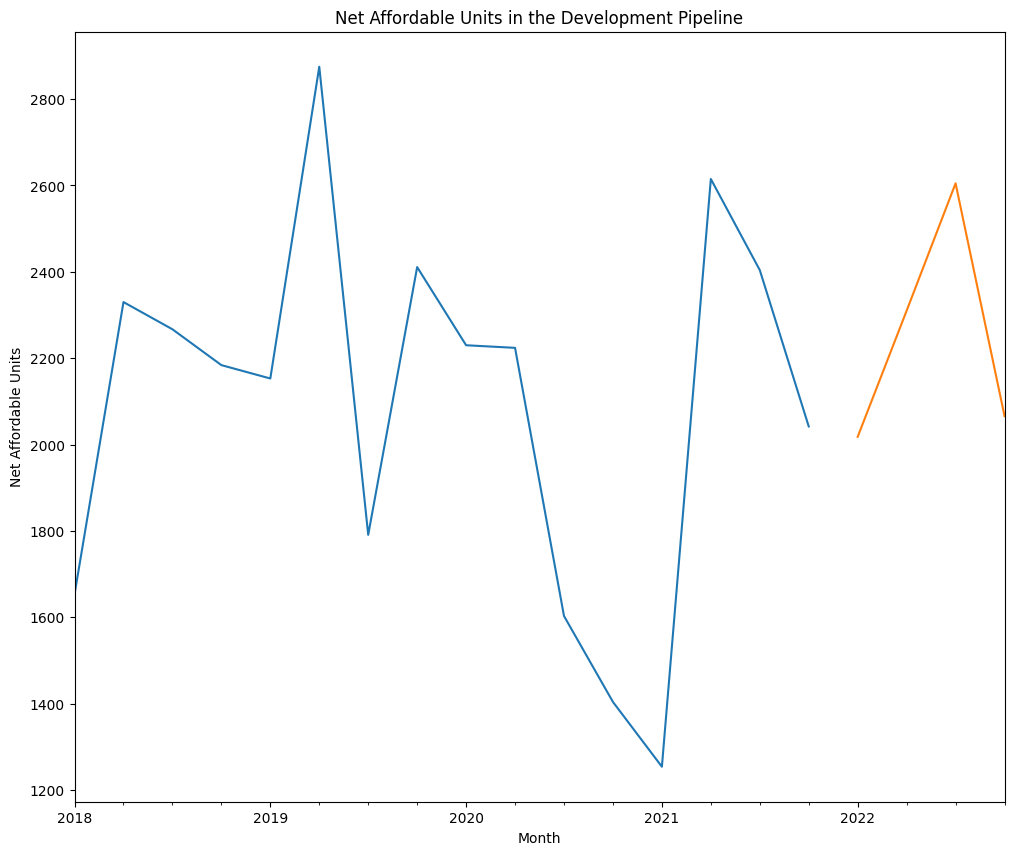

In [919]:
# displays graph of train and test data for net units
train['affordablenet'].plot()
test['affordablenet'].plot(figsize = (12, 10), 
                           xlabel = 'Month',
                           ylabel = 'Net Affordable Units',
                           title = 'Net Affordable Units in the Development Pipeline');

In [920]:
# creates a prediction data frame which is a copy of the test data
aff_preds = test.copy()

aff_preds

,affordablenet
yearqtr,
2022-03-31,2018.0
2022-06-30,2310.0
2022-09-30,2605.0
2022-12-31,2066.0


In [921]:
# creates a prediction column based on the last value in the train dataset
aff_preds['last'] = train['affordablenet'][-1]

aff_preds

,affordablenet,last
yearqtr,,
2022-03-31,2018.0,2042.0
2022-06-30,2310.0,2042.0
2022-09-30,2605.0,2042.0
2022-12-31,2066.0,2042.0


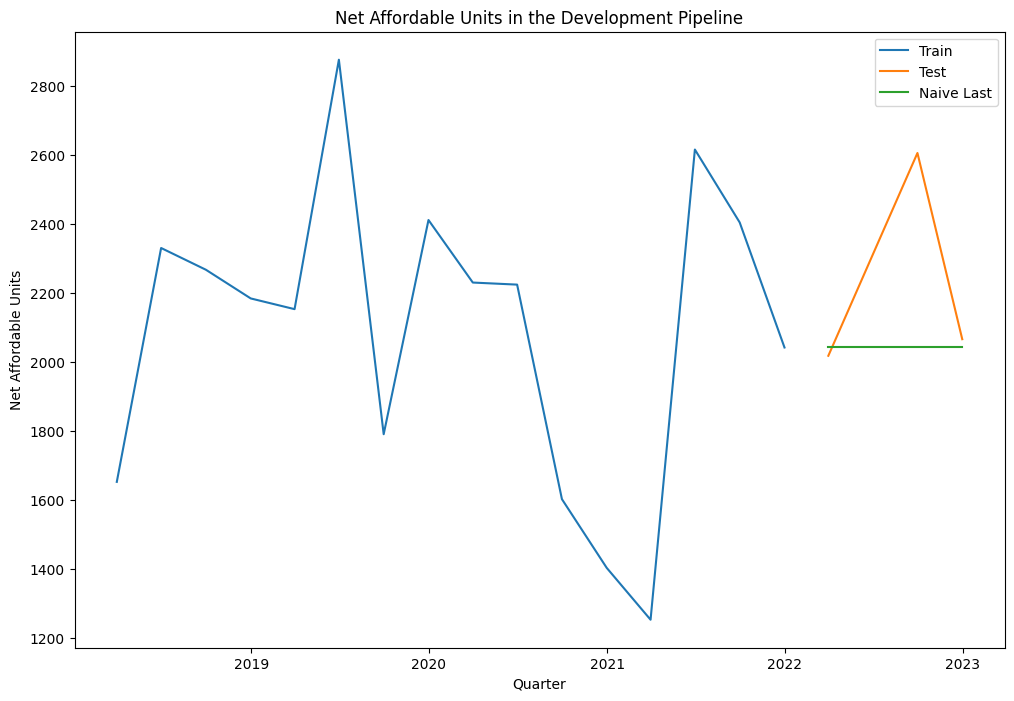

In [922]:
# displays the graph of the train, test and naive last data
plt.figure(figsize = (12, 8))

plt.plot(train.index, train['affordablenet'], label = 'Train')
plt.plot(test.index, test['affordablenet'], label = 'Test')
plt.plot(aff_preds.index, aff_preds['last'], label = 'Naive Last')

plt.legend(loc = 'best')
plt.xlabel('Quarter')
plt.ylabel('Net Affordable Units')
plt.title('Net Affordable Units in the Development Pipeline');

In [923]:
# shows the root mean squared error for the naive last prediction
mean_squared_error(aff_preds['affordablenet'], aff_preds['last'], squared = False)

312.2278815224547

In [924]:
# creates a column the simple mean based on the training historic mean
aff_preds['simple_mean'] = train['affordablenet'].mean()

aff_preds.head()

,affordablenet,last,simple_mean
yearqtr,,,
2022-03-31,2018.0,2042.0,2090.0
2022-06-30,2310.0,2042.0,2090.0
2022-09-30,2605.0,2042.0,2090.0
2022-12-31,2066.0,2042.0,2090.0


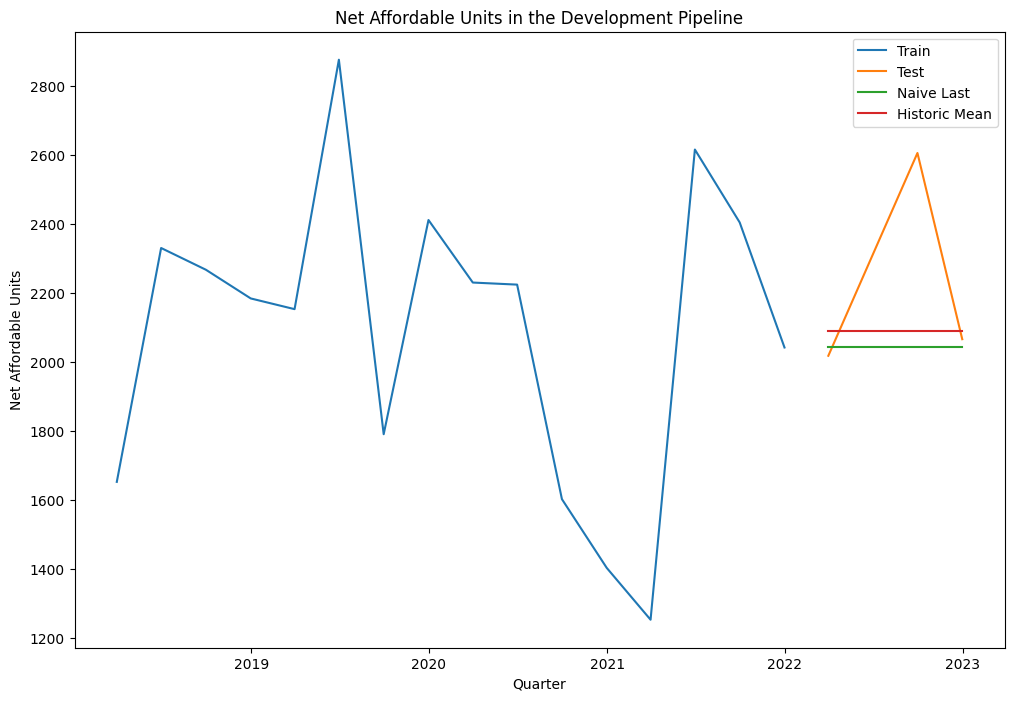

In [925]:
# graphs the train and test data with both the naive last and historic mean
plt.figure(figsize = (12, 8))

plt.plot(train.index, train['affordablenet'], label = 'Train')
plt.plot(test.index, test['affordablenet'], label = 'Test')
plt.plot(aff_preds.index, aff_preds['last'], label = 'Naive Last')
plt.plot(aff_preds.index, aff_preds['simple_mean'], label = 'Historic Mean')

plt.legend(loc = 'best')
plt.xlabel('Quarter')
plt.ylabel('Net Affordable Units')
plt.title('Net Affordable Units in the Development Pipeline');

In [926]:
# shows the root mean squared error for the historical mean
mean_squared_error(aff_preds['affordablenet'], aff_preds['simple_mean'], squared = False)

282.5707875913574

Looking at the development pipeline of net affordable units, the naive last null model has a RMSE of ~312 net affordable units and the historic mean null model has a RMSE of ~283 net affordable units. The historic mean is a slightly better predictor than the naive last, so we shall use this for assessing our other time series models moving forward.

In [935]:
# fit a simple exponential smoothing model
simexp = SimpleExpSmoothing(train['affordablenet']).fit(smoothing_level = .5, optimized = False)

In [936]:
# shows a summary of the exponential smoothing
simexp.summary()

Dep. Variable:,affordablenet,No. Observations:,16
Model:,SimpleExpSmoothing,SSE,3995411.622
Optimized:,False,AIC,202.849
Trend:,None,BIC,204.394
Seasonal:,None,AICC,206.485
Seasonal Periods:,None,Date:,"Sat, 16 Sep 2023"
Box-Cox:,False,Time:,16:16:52
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.5000000,alpha,False
initial_level,1653.0000,l.0,False


In [937]:
# adds the simple exponential smoothing forecast to the predictions
aff_preds['simexp'] = simexp.forecast(len(test))

aff_preds

,affordablenet,last,simple_mean,hw,simexp
yearqtr,,,,,
2022-03-31,2018.0,2042.0,2090.0,2053.447597,2131.171783
2022-06-30,2310.0,2042.0,2090.0,2051.861444,2131.171783
2022-09-30,2605.0,2042.0,2090.0,2050.275291,2131.171783
2022-12-31,2066.0,2042.0,2090.0,2048.689138,2131.171783


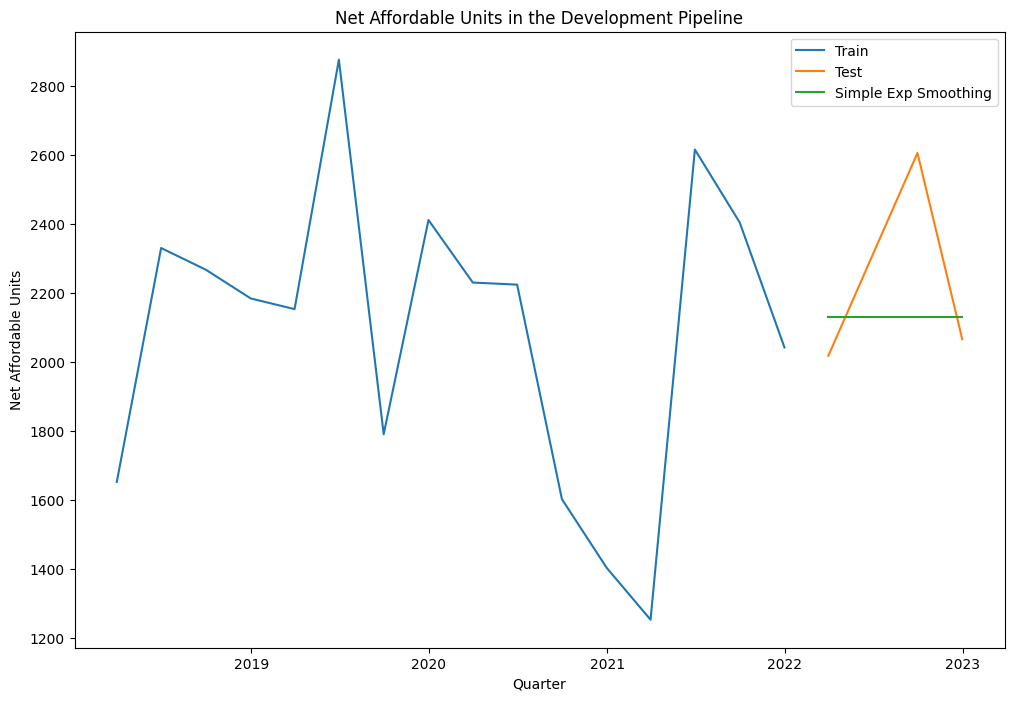

In [938]:
# graphs the train and test data with simple exponential smoothing
plt.figure(figsize = (12, 8))

plt.plot(train.index, train['affordablenet'], label = 'Train')
plt.plot(test.index, test['affordablenet'], label = 'Test')
plt.plot(aff_preds.index, aff_preds['simexp'], label = 'Simple Exp Smoothing')

plt.legend(loc = 'best')
plt.xlabel('Quarter')
plt.ylabel('Net Affordable Units')
plt.title('Net Affordable Units in the Development Pipeline');

In [953]:
# shows the root mean squared error for simple exponential smoothing
mean_squared_error(aff_preds['affordablenet'], aff_preds['simexp'], squared = False)

261.5090456195104

In [940]:
# train a Holt Winters model
hw = ExponentialSmoothing(train['affordablenet'],
                         trend = 'add').fit()

In [941]:
# show a summary of Holt Winters
hw.summary()

Dep. Variable:,affordablenet,No. Observations:,16
Model:,ExponentialSmoothing,SSE,3422718.813
Optimized:,True,AIC,204.374
Trend:,Additive,BIC,207.464
Seasonal:,None,AICC,213.707
Seasonal Periods:,None,Date:,"Sat, 16 Sep 2023"
Box-Cox:,False,Time:,16:18:04
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.2191815,alpha,True
smoothing_trend,0.0006715,beta,True


In [942]:
# add a column of Holt Winters predictions
aff_preds['hw'] = hw.forecast(len(test))

aff_preds

,affordablenet,last,simple_mean,hw,simexp
yearqtr,,,,,
2022-03-31,2018.0,2042.0,2090.0,2053.447597,2131.171783
2022-06-30,2310.0,2042.0,2090.0,2051.861444,2131.171783
2022-09-30,2605.0,2042.0,2090.0,2050.275291,2131.171783
2022-12-31,2066.0,2042.0,2090.0,2048.689138,2131.171783


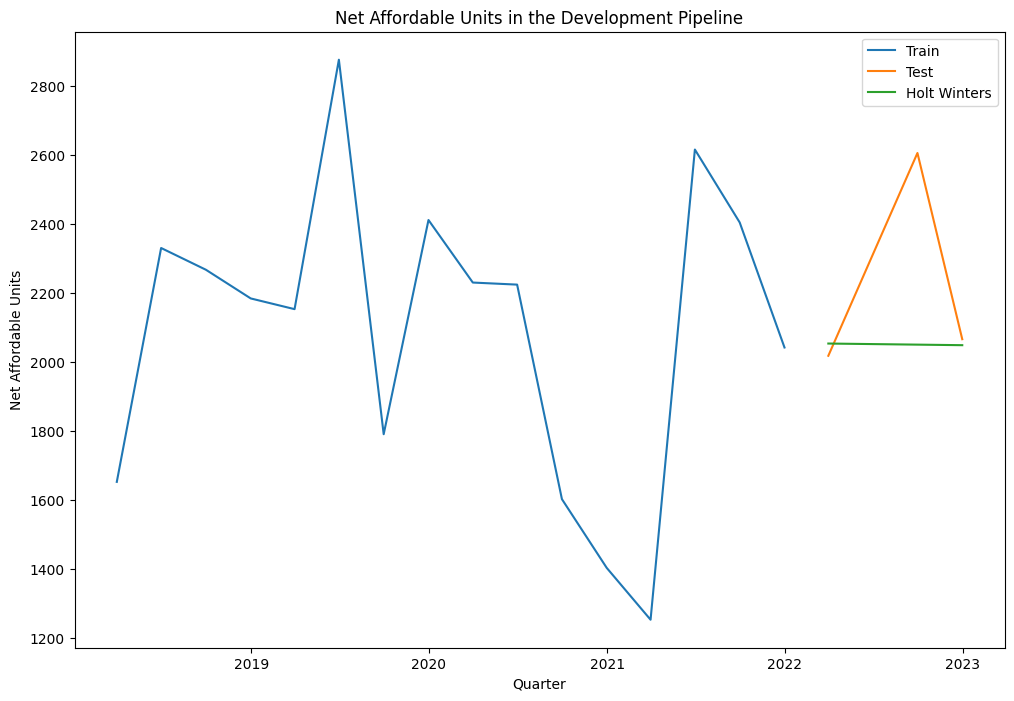

In [943]:
# graphs the train and test data with Holt Winters
plt.figure(figsize = (12, 8))

plt.plot(train.index, train['affordablenet'], label = 'Train')
plt.plot(test.index, test['affordablenet'], label = 'Test')
plt.plot(aff_preds.index, aff_preds['hw'], label = 'Holt Winters')

plt.legend(loc = 'best')
plt.xlabel('Quarter')
plt.ylabel('Net Affordable Units')
plt.title('Net Affordable Units in the Development Pipeline');

In [944]:
# shows the root mean squared error for the historical mean
mean_squared_error(aff_preds['affordablenet'], aff_preds['hw'], squared = False)

306.55799403896447

In [945]:
model = pmd.auto_arima(train['affordablenet'], trace = True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=249.057, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=243.250, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=245.088, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=245.073, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=292.699, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=247.073, Time=0.01 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.109 seconds


In [946]:
model

ARIMA(order=(0, 0, 0), scoring_args={}, suppress_warnings=True)

In [947]:
model.predict()

2022-03-31    2090.0
2022-06-30    2090.0
2022-09-30    2090.0
2022-12-31    2090.0
2023-03-31    2090.0
2023-06-30    2090.0
2023-09-30    2090.0
2023-12-31    2090.0
2024-03-31    2090.0
2024-06-30    2090.0
Freq: Q-DEC, dtype: float64

In [948]:
aff_preds['sarima_auto'] = model.predict(test.shape[0])

In [949]:
aff_preds

,affordablenet,last,simple_mean,hw,simexp,sarima_auto
yearqtr,,,,,,
2022-03-31,2018.0,2042.0,2090.0,2053.447597,2131.171783,2090.0
2022-06-30,2310.0,2042.0,2090.0,2051.861444,2131.171783,2090.0
2022-09-30,2605.0,2042.0,2090.0,2050.275291,2131.171783,2090.0
2022-12-31,2066.0,2042.0,2090.0,2048.689138,2131.171783,2090.0


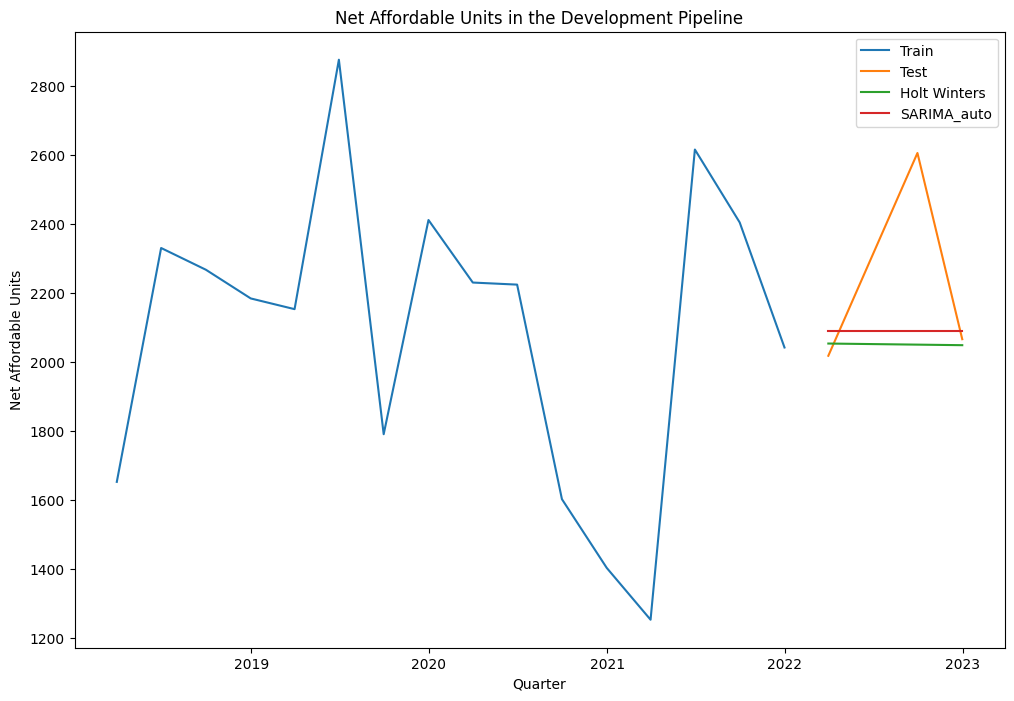

In [951]:
# graphs the train and test data with both the naive last and historic mean
plt.figure(figsize = (12, 8))

plt.plot(train.index, train['affordablenet'], label = 'Train')
plt.plot(test.index, test['affordablenet'], label = 'Test')
plt.plot(aff_preds.index, aff_preds['hw'], label = 'Holt Winters')
plt.plot(aff_preds['sarima_auto'], label = 'SARIMA_auto')

plt.legend(loc = 'best')
plt.xlabel('Quarter')
plt.ylabel('Net Affordable Units')
plt.title('Net Affordable Units in the Development Pipeline');

In [952]:
mean_squared_error(test['affordablenet'], aff_preds['sarima_auto'], squared = False)

282.57078759135686

In the results of our simple exponential smoothing, Holt Winters, and ARIMA models, we can see an RMSE of ~262 net affordable units, ~307 net affordable units, and ~283 net affordable units, respectively. This would seem to indicate that the simple exponential smoothing model performs the best in predicting future net affordable units in the pipeline with the lowest root mean squared error, albeit only somewhat better than the historic mean. In fact, just like in our previous mean monthly new construction times series models, when we look at the results of our auto-ARIMA, we can see that the best fit was zero lags and zero differencing. Once again, rather than even fitting an autoregression, the model fitted the historic mean as its predictions and performed as well as our null. Suffice it to say that we could use a simple exponential smoothing model here to get slightly better predictions but overall we can presume that past net affordable units in the pipeline are not predictive of future affordable units in the pipeline. A univariate time series model here just does not work well for making predictions.

We shall check the possibility of a multivariate time series with a vector autoregression below. The reader will recall that for both the net units and net affordable units variables that we failed to reject the null hypothesis of the Augmented Dickey Fuller test, so we could not assume stationarity. However, according to our auto-ARIMA, no lags or differencing was used, so we may be able to safely assume differencing may not be sufficient enough in and of itself to presume stationarity for the sake of creating a time series model. We shall check below.

In [954]:
# display the correlations between variables
constr_qtr.corr()

,unitsnet,affordablenet
unitsnet,1.00000,0.30288
affordablenet,0.30288,1.00000


In [962]:
# shows results of ADF for net units based on one difference
interpret_dftest(adfuller(constr_qtr['unitsnet'].diff().dropna()))

,0
Test Statistic,0.214820
p-value,0.973081
Lag Used,7.000000


In [963]:
# shows results of ADF for net units based on two differences
interpret_dftest(adfuller(constr_qtr['unitsnet'].diff().diff().dropna()))

,0
Test Statistic,-1.010452e+01
p-value,1.038338e-17
Lag Used,7.000000e+00


In [964]:
# shows results of ADF for net affordable units based on one difference
interpret_dftest(adfuller(constr_qtr['affordablenet'].diff().dropna()))

,0
Test Statistic,-3.194835
p-value,0.020286
Lag Used,6.000000


In [965]:
# shows results of ADF for net affordable units based on two differences
interpret_dftest(adfuller(constr_qtr['affordablenet'].diff().diff().dropna()))

,0
Test Statistic,-1.122090
p-value,0.706183
Lag Used,7.000000


In [966]:
# shows results of ADF for net affordable units based on three differences
interpret_dftest(adfuller(constr_qtr['affordablenet'].diff().diff().diff().dropna()))

,0
Test Statistic,-1.048561
p-value,0.735144
Lag Used,5.000000


After differencing and running multiple Augmented Dickey Fuller tests, we can reasonably presume that a vector autoregression does not make sense here. The quarterly pipeline data fails the stationarity test for net units for one difference with a p-value of ~0.97 and only passes at two differences with over 99% confidence at a p-value of 0.00000000000000001. However, the quarterly net affordable pipeline units is even worse with one difference having a p-value of ~0.02, two differences having a p-value of ~0.71, and three differences having a p-value of ~0.74. This is not too surprising since our auto-ARIMA model used no lags and no differencing, indicating that the historic mean is as good a fit as trying to predict with any time series model. Additionally, most times series models do not require any further than second-degree differencing to presume stationarity if they are suitable for modeling. Since these p-values do not meet the 0.01 threshold commonly associated with assumption to reject the null hypothesis, we cannot presume stationarity and unfortunately, have shown that for this dataset on housing and affordable housing a time series model just does not make sense.